In [1]:
import torch
import einops

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import itertools

from utils.components import *
from utils.config import *
from utils.einmask import EinMask
from utils.dataset import NinoData

from utils.masking import *

from omegaconf import OmegaConf
from dataclasses import replace

import torch_harmonics


In [2]:
mpl.rcParams['figure.dpi'] = 300            # High resolution
mpl.rcParams['font.size'] = 9               # or 10, depending on guidelines
mpl.rcParams['axes.linewidth'] = 0.5        # Axis line thickness
mpl.rcParams['lines.linewidth'] = 1.0       # Default plot line thickness
mpl.rcParams['legend.fontsize'] = 7         # Legend font size

In [3]:
ds_n = "piControl"
run_n = 2339844
eval_data = xr.open_zarr(f"runs/{run_n}/{ds_n}_eval.zarr").sel(time=slice("1950-01-01", "2020-01-01"))

In [4]:
eval_data

<xarray.Dataset> Size: 4GB
Dimensions:           (ens: 4, lag: 48, lat: 41, lon: 91, time: 540)
Coordinates:
  * ens               (ens) int64 32B 0 1 2 3
  * lag               (lag) int64 384B 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48
  * lat               (lat) float64 328B -20.0 -19.0 -18.0 ... 18.0 19.0 20.0
  * lon               (lon) float64 728B 90.0 92.0 94.0 ... 266.0 268.0 270.0
    month             (time) int64 4kB ...
  * time              (time) object 4kB 1950-01-01 00:00:00 ... 1994-12-01 00...
    variable          <U12 48B ...
Data variables:
    temp_ocn_0a_pred  (time, lag, lat, lon, ens) float64 3GB ...
    temp_ocn_0a_tgt   (time, lag, lat, lon) float64 774MB ...

In [5]:
def crps_gaussian(x: np.ndarray, mu: np.ndarray, std: np.ndarray) -> np.ndarray:
    from scipy.special import erf
    """CRPS for Gaussian distribution.

    Args:
        x (np.ndarray): Ground truth data of size (n_samples, n_features)
        mu (np.ndarray): Mean of size (n_samples, n_features)
        std (np.ndarray): Standard deviation of size (n_samples, n_features)

    Returns:
        crps (np.ndarray): CRPS of size (n_samples, n_features) 
    """
    sqrtPi = np.sqrt(np.pi)
    z = (x - mu) / std 
    phi = np.exp(-z ** 2 / 2) / (np.sqrt(2) * sqrtPi) #standard normal pdf
    crps = std * (z * erf(z / np.sqrt(2)) + 2 * phi - 1 / sqrtPi) #crps as per Gneiting et al 2005
    return crps 

def compute_rank_histogram(obs, ens):
    """
    Compute the rank histogram for a set of observations and ensemble forecasts.
    
    Parameters
    ----------
    obs : ndarray of shape (M,)
        The observations, flattened along all spatial/temporal dimensions.
    ens : ndarray of shape (M, N)
        The ensemble forecasts, where M is the total number of samples
        and N is the number of ensemble members.

    Returns
    -------
    ranks : ndarray of shape (N+1,)
        The rank histogram counts for ranks from 0 to N.
    """
    M, N = ens.shape
    # Initialize counts for each possible rank: 0..N
    rank_counts = np.zeros(N + 1, dtype=np.int64)

    # For each sample, compute how many ensemble members are less than obs
    # This integer is the rank of obs in the sorted ensemble.
    # rank = 0 means obs is smaller than all ensemble members,
    # rank = N means obs is larger than all ensemble members.
    for i in range(M):
        rank = np.sum(ens[i, :] < obs[i])
        rank_counts[rank] += 1

    return rank_counts / M

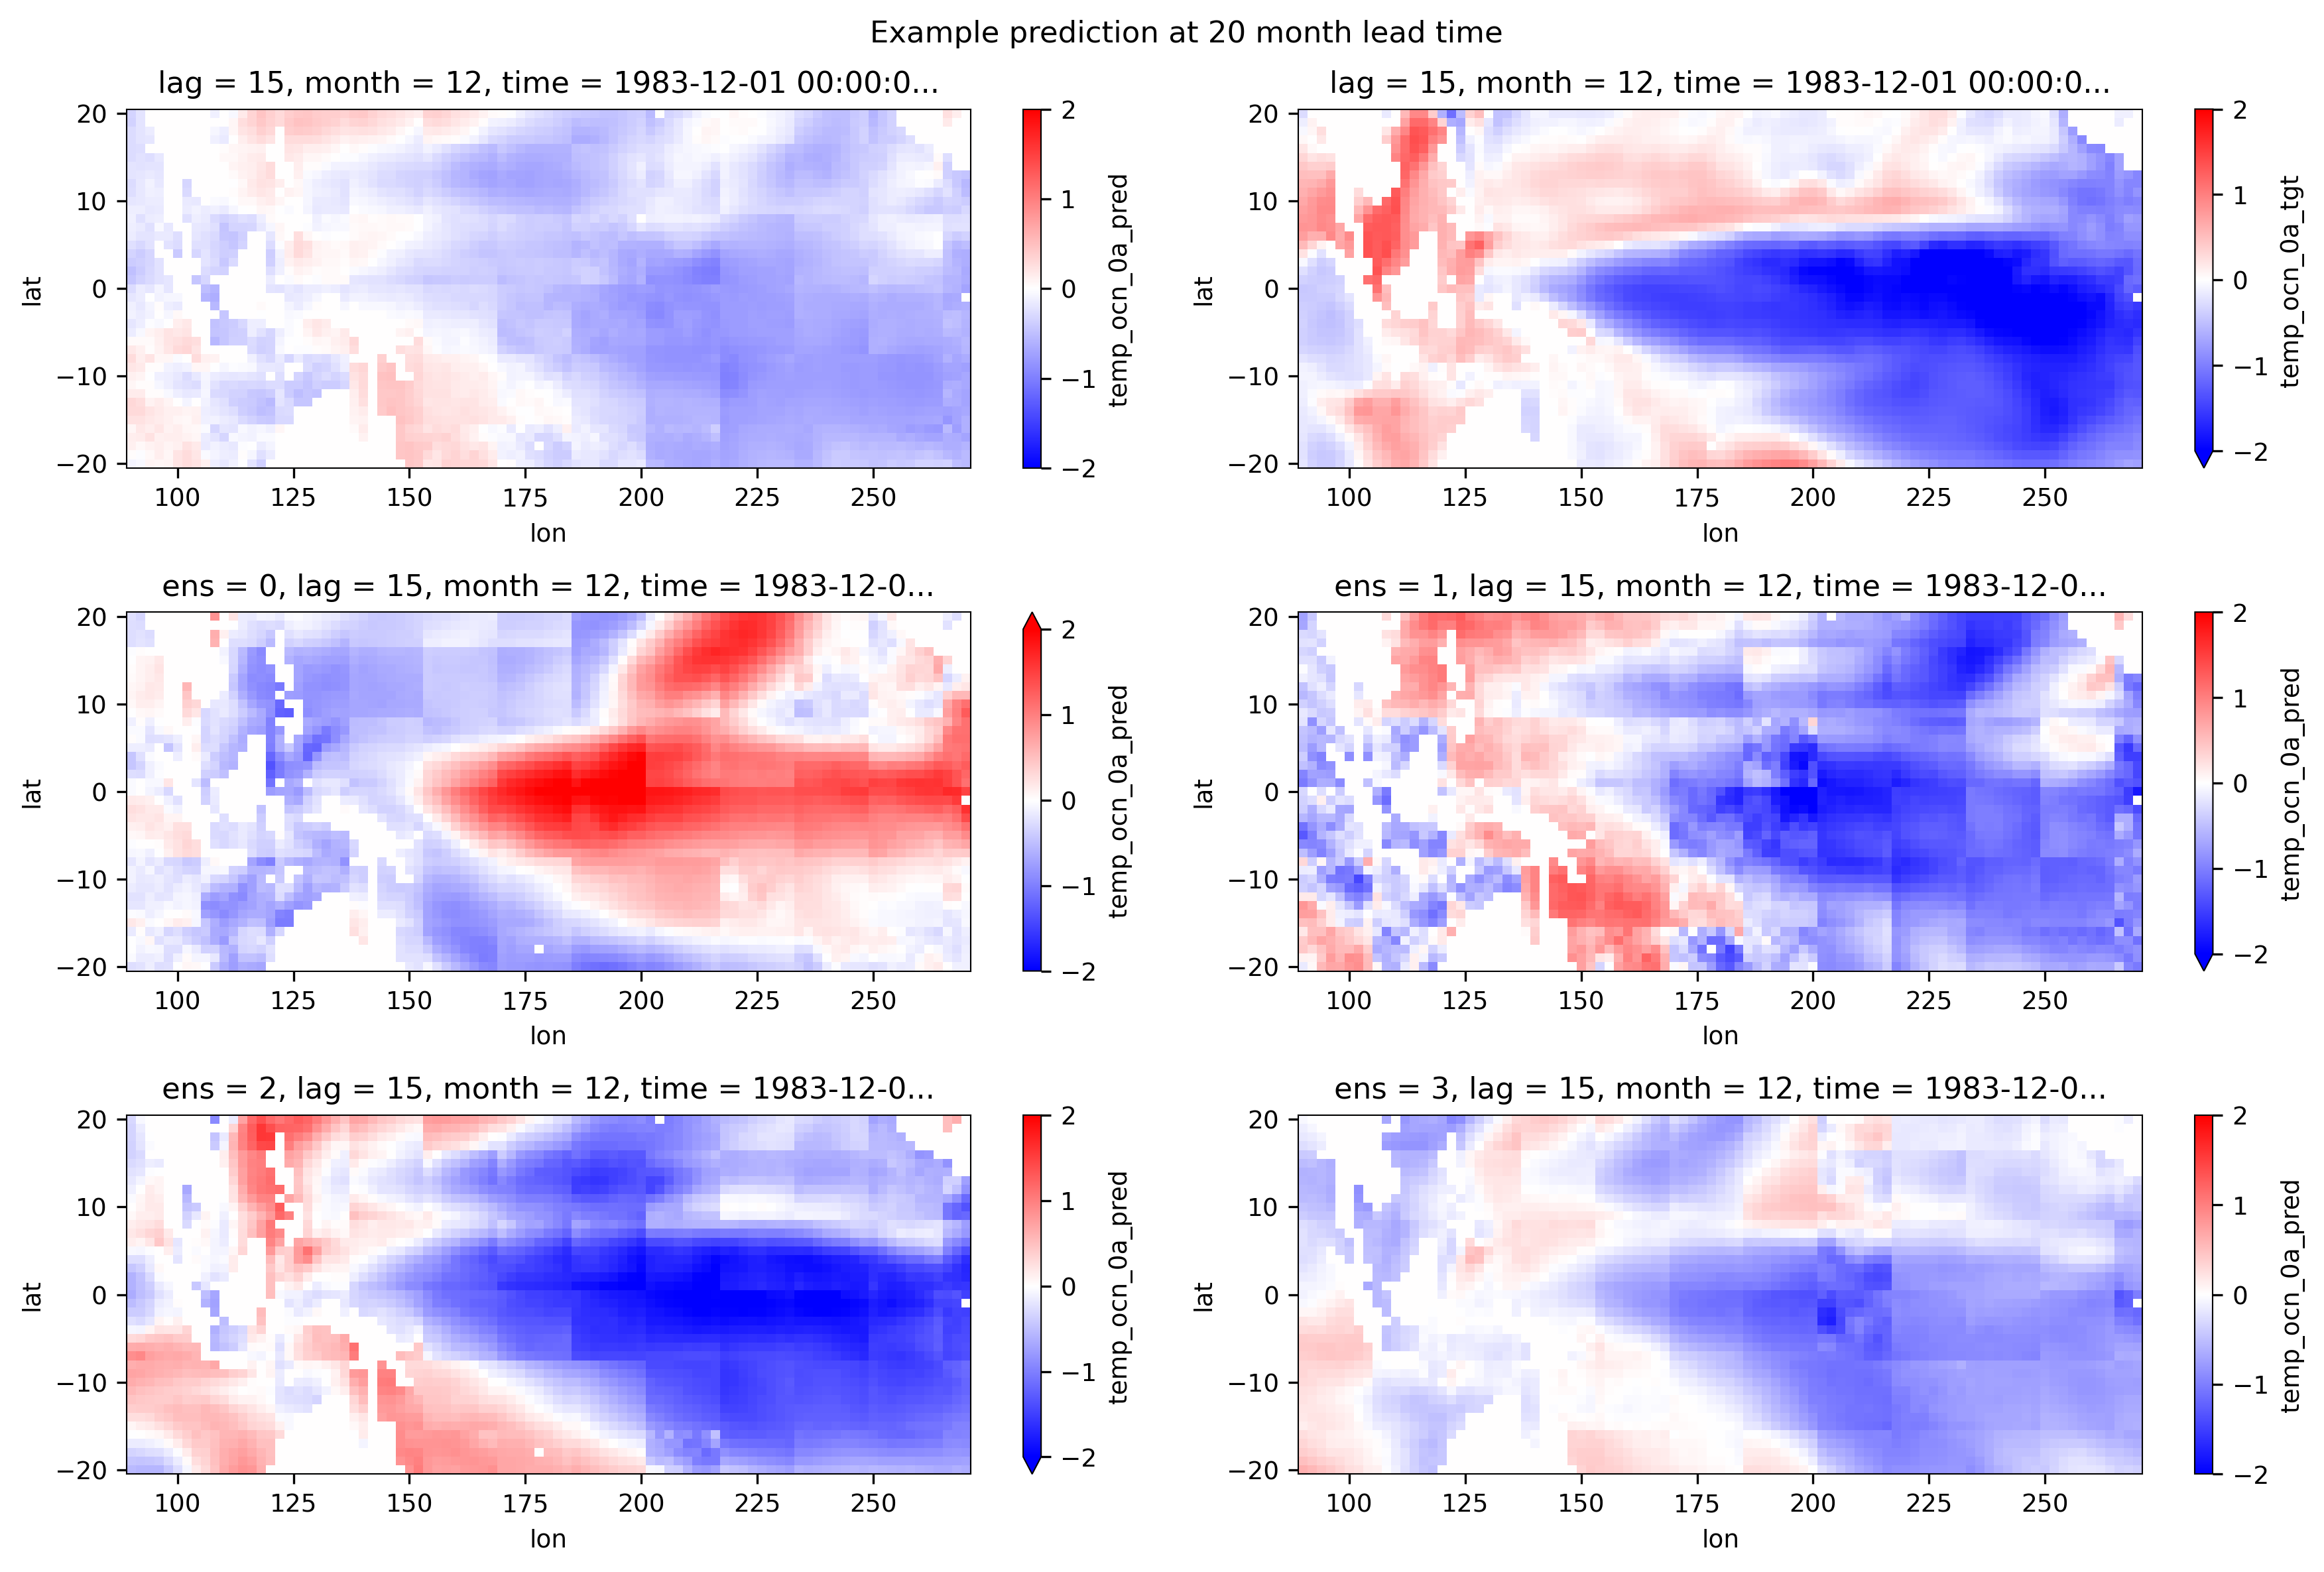

In [6]:
plt.figure(figsize=(12,8))
tau = 15
date_id = '1983-12-01'#'1996-12-01' #'2015-12-01' #
plt.suptitle("Example prediction at 20 month lead time")
plt.subplot(321)
eval_data['temp_ocn_0a_pred'].sel(time=date_id, lag=tau).mean("ens").plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.subplot(322)
eval_data['temp_ocn_0a_tgt'].sel(time=date_id, lag=tau).plot(vmin=-2, vmax = 2, cmap= 'bwr')
for i in range(0, 4):
    plt.subplot(3, 2, 3 + i)
    eval_data['temp_ocn_0a_pred'].sel(time=date_id, lag=tau, ens=i).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.tight_layout()

plt.savefig('samples.png')

/tmp/ipykernel_844546/2011740608.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  E = eval_data.dims['ens']


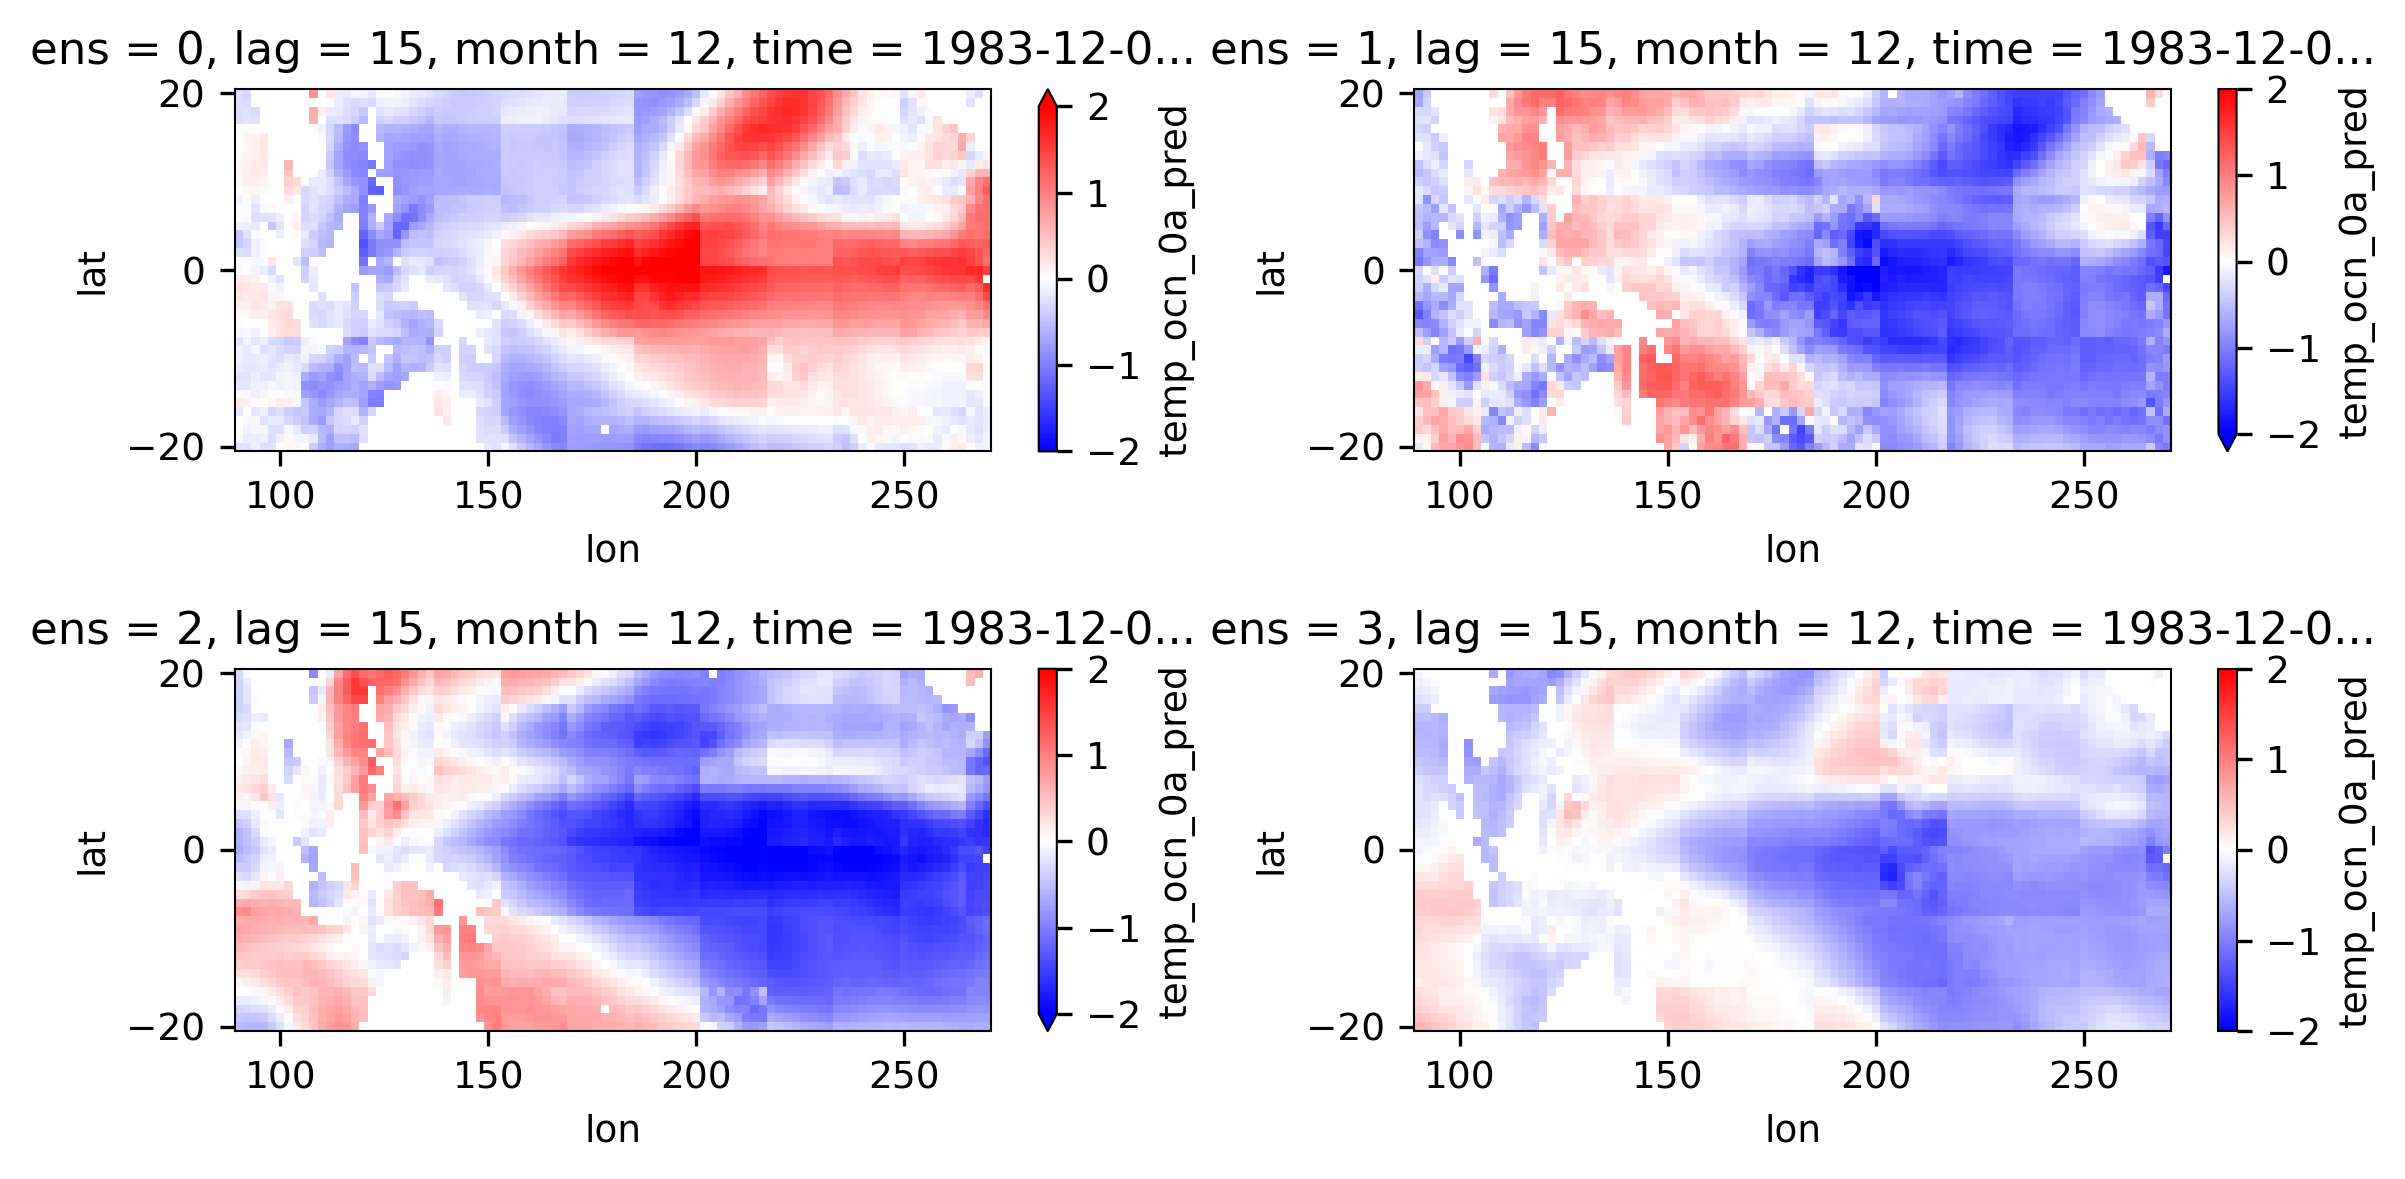

In [7]:
E = eval_data.dims['ens']
plt.figure(figsize=(4 * (E // 2), 2 * (E // 2)))
for i in range(0, E):
    plt.subplot(E // 2, 2, i + 1)
    eval_data['temp_ocn_0a_pred'].sel(time=date_id, lag=tau, ens=i).plot(vmin=-2, vmax = 2, cmap= 'bwr')
plt.tight_layout()
plt.savefig('ensembles.png')

In [8]:
import math

def get_field_metrics(eval_data: xr.Dataset):
    for var in ["temp_ocn_0a"]:
        tgt, pred = eval_data[f"{var}_tgt"], eval_data[f'{var}_pred']
        pcc = xr_pcc(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        rmse = xr_rmse(pred.mean('ens'), tgt, ('lat', 'lon')).mean(('time'))
        ssr = xr_spread_skill(pred, tgt, ('lat', 'lon')).mean(('time'))
        
    return {
        "pcc": pcc, "rmse": rmse, "ssr": ssr
    }

def get_nino_metrics( eval_data: xr.Dataset):
    nino34_tgt, nino34_pred = get_nino34(eval_data["temp_ocn_0a_tgt"]), get_nino34(eval_data["temp_ocn_0a_pred"]).mean("ens")
    nino4_tgt, nino4_pred = get_nino4(eval_data["temp_ocn_0a_tgt"]), get_nino4(eval_data["temp_ocn_0a_pred"]).mean("ens")
    
    nino34_pcc = xr_pcc(nino34_pred, nino34_tgt, ("time",))
    nino4_pcc = xr_pcc(nino4_pred, nino4_tgt, ("time",))

    nino34_rmse = xr_rmse(nino34_pred, nino34_tgt, ("time",))
    nino4_rmse = xr_rmse(nino4_pred, nino4_tgt, ("time",))

    nino4_thresh_month =  1 + np.argwhere(nino4_pcc.values > 0.5).max(initial=0)
    nino34_thresh_month = 1 + np.argwhere(nino34_pcc.values > 0.5).max(initial=0)

    nino4_ssr = xr_spread_skill(get_nino4(eval_data["temp_ocn_0a_pred"]), nino4_tgt, ("time",))
    nino34_ssr = xr_spread_skill(get_nino34(eval_data["temp_ocn_0a_pred"]), nino34_tgt, ("time",))

    return {
        "nino34_pcc": nino34_pcc, "nino4_pcc": nino4_pcc,
        "nino34_rmse": nino34_rmse, "nino4_rmse": nino4_rmse,
        "nino34_thresh_month": nino34_thresh_month,
        "nino4_thresh_month": nino4_thresh_month,
        "nino34_ssr": nino34_ssr, "nino4_ssr": nino4_ssr
    }
    

@staticmethod
def get_nino4(da: xr.DataArray):
    return da.sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])

@staticmethod
def get_nino34(da: xr.DataArray):
    return da.sel(lon=slice(190, 240), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])

@staticmethod
def xr_pcc(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    num = (pred * obs).sum(dim)
    denom = np.sqrt((pred**2).sum(dim)) * np.sqrt((obs**2).sum(dim))
    return num / denom

@staticmethod
def xr_rmse(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    return np.sqrt(((pred - obs) ** 2).mean(dim))

@staticmethod
def xr_spread_skill(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
    K = pred.sizes["ens"]
    correction = math.sqrt((K + 1) / K)
    mean = pred.mean("ens")
    spread = np.sqrt(pred.var("ens").mean(dim))
    skill = np.sqrt(((obs - mean) ** 2).mean(dim))
    return correction * (spread / skill)


In [9]:
field_metrics = get_field_metrics(eval_data)
nino_metrics = get_nino_metrics(eval_data)

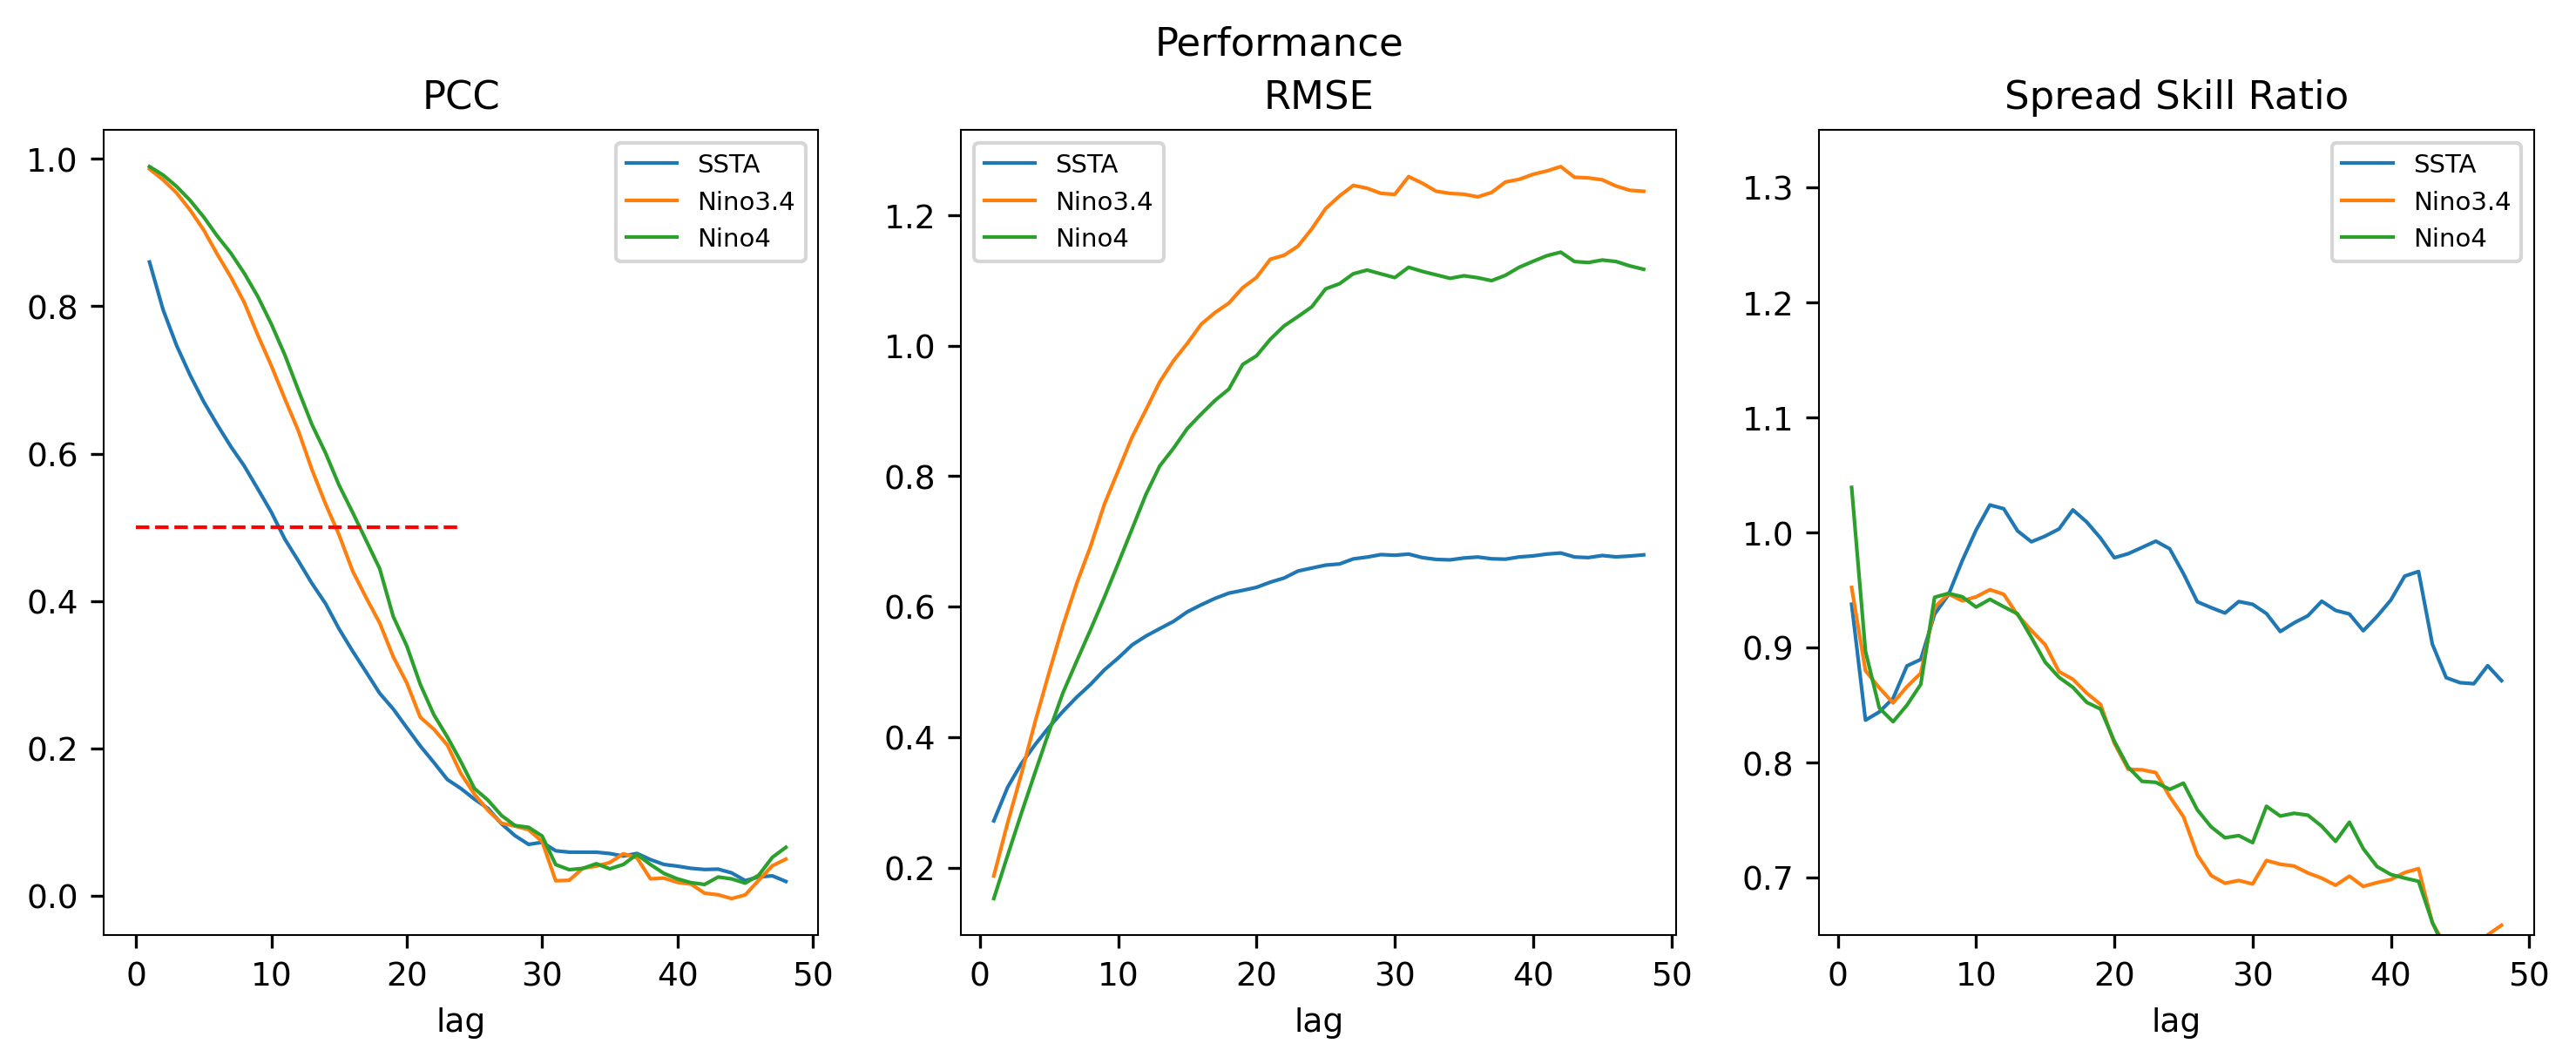

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(131)
field_metrics["pcc"].plot()
nino_metrics["nino34_pcc"].plot()
nino_metrics["nino4_pcc"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.title("PCC")
plt.subplot(132)
field_metrics["rmse"].plot()
nino_metrics["nino34_rmse"].plot()
nino_metrics["nino4_rmse"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.title("RMSE")
plt.subplot(133)
field_metrics["ssr"].plot()
nino_metrics["nino34_ssr"].plot()
nino_metrics["nino4_ssr"].plot()
plt.legend(["SSTA", "Nino3.4", "Nino4"])
plt.ylim(0.65, 1.35)
plt.title("Spread Skill Ratio")
plt.suptitle(f'Performance')
plt.savefig('metrics.png')

In [11]:
geoformer_acc_nino4 = [0.994,0.963,0.931,0.9,0.87,0.843,0.816,0.789,0.768,0.748,0.732,0.718,0.703,0.677,0.652,0.624,0.592,0.557,0.512,0.455]
geoformer_rmse_nino4 = [0.104,0.167,0.23,0.295,0.339,0.38,0.41,0.427,0.445,0.459,0.467,0.481,0.504,0.527,0.537,0.553,0.592,0.622,0.637,0.672]


Text(0.5, 0.98, 'Nino4 Metric Comparison on PiControl')

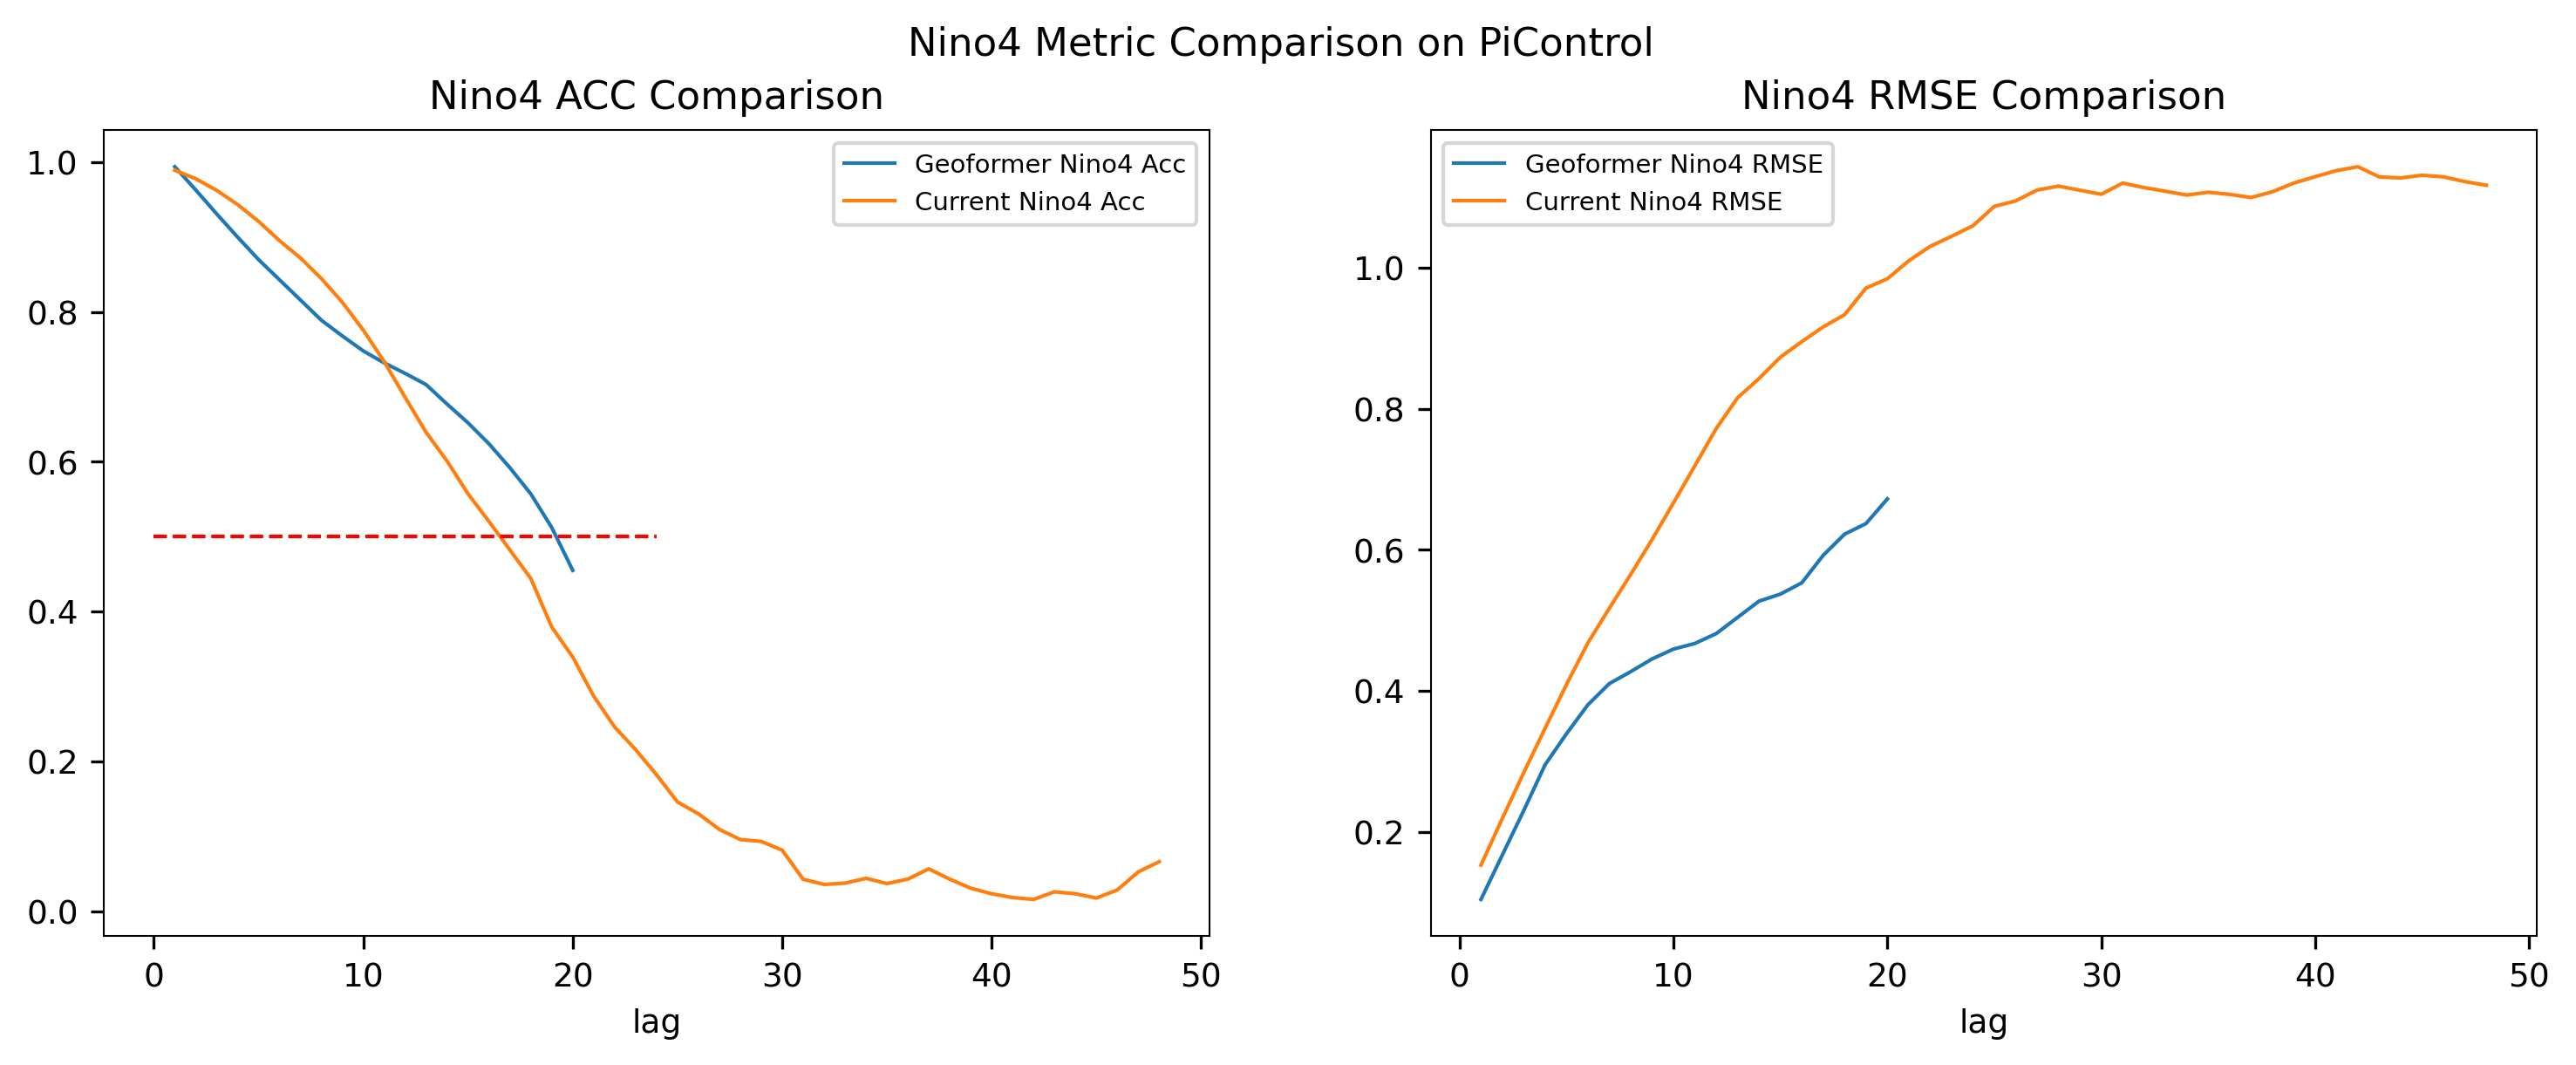

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1), geoformer_acc_nino4, label='Geoformer Nino4 Acc')
#plt.plot(np.arange(1, len(nino4_acc_values_old) + 1), nino4_acc_values_old, label='ICML25 Nino4 Acc')
nino_metrics["nino4_pcc"].plot(label='Current Nino4 Acc')
plt.hlines(0.5, xmin=0, xmax=24, colors='r', linestyles='dashed')
plt.legend()
plt.title("Nino4 ACC Comparison")
plt.subplot(122)
plt.plot(np.arange(1, len(geoformer_acc_nino4) + 1),geoformer_rmse_nino4, label='Geoformer Nino4 RMSE')
#plt.plot(np.arange(1, len(nino4_rmse_values_old) + 1),nino4_rmse_values_old, label='ICML Nino4 RMSE')
nino_metrics["nino4_rmse"].plot(label='Current Nino4 RMSE')
plt.legend()
plt.title("Nino4 RMSE Comparison")
plt.suptitle("Nino4 Metric Comparison on PiControl")


In [13]:
lsm = eval_data.temp_ocn_0a_tgt.isel(time = 0, lag = 0) != 0
lsm = lsm.rename("lsm")
del lsm["time"]
del lsm["lag"]
del lsm["month"]
eval_data = xr.merge([eval_data, lsm]).compute()

num_predictors = len(eval_data.ens)

filtered_tgt = eval_data.temp_ocn_0a_tgt.where(eval_data.lsm)#.rolling(time = 3).mean()
filtered_pred = eval_data.temp_ocn_0a_pred.where(eval_data.lsm)#.rolling(time = 3).mean()

filtered_mean = filtered_pred.mean("ens") 
filtered_std = filtered_pred.std("ens") 
filtered_var = filtered_pred.var("ens") 

filtered_tgt_nino4 = filtered_tgt.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"])#.rolling(time = 3).mean()
filtered_pred_nino4 = filtered_pred.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"])#.rolling(time = 3).mean()
filtered_mean_nino4 = filtered_pred_nino4.mean("ens") 
filtered_std_nino4 = filtered_pred_nino4.std("ens") 
filtered_var_nino4 = filtered_pred_nino4.var("ens") 



In [14]:
monthly_accs, monthly_rmse, monthly_crps, monthly_ssr = [], [], [], []
monthly_nino_accs, monthly_nino_rmse, monthly_nino_crps, monthly_nino_ssr = [], [], [], []

clim_rmse, clim_crps = [], []
clim_nino_rmse, clim_nino_crps = [], []

for month in range(1, 13):
    # 1. Select the data for the month and stack the spatial dimensions
    tgt = filtered_tgt.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    mean = filtered_mean.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    std = filtered_std.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    var = filtered_var.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    # 1.1 For nino4 we don't need to stack space
    tgt_nino4 = filtered_tgt_nino4.sel(time = filtered_mean["time.month"] == month)
    mean_nino4 = filtered_mean_nino4.sel(time = filtered_mean["time.month"] == month)
    std_nino4 = filtered_std_nino4.sel(time = filtered_mean["time.month"] == month)
    var_nino4 = filtered_var_nino4.sel(time = filtered_mean["time.month"] == month)
    # 1. Compute climatology statistics
    clim_da_mean = tgt.mean("time")
    clim_da_std = tgt.std("time")

    clim_nino_mean = tgt_nino4.mean("time")
    clim_nino_std = tgt_nino4.std("time")
    
    # 2. Compute CRPS for each sample
    crps = crps_gaussian(x = tgt, mu = mean, std = std)  # shape (time, lag, space)
    monthly_crps += [crps.mean(["space", "time"])]
    crps_nino4 = crps_gaussian(tgt_nino4, mean_nino4, std_nino4) # shape (time, lag)
    monthly_nino_crps += [crps_nino4.mean("time")]
    crps_clim = crps_gaussian(tgt, clim_da_mean, clim_da_std)
    clim_crps += [crps_clim.mean(["space", "time"])]
    crps_clim_nino4 = crps_gaussian(tgt_nino4, clim_nino_mean, clim_nino_std)
    clim_nino_crps += [crps_clim_nino4.mean("time")]
    # 3. Compute RMSE for each sample
    rmse = np.sqrt(((tgt - mean)**2).mean(["space", "time"]))
    rmse_nino4 = np.sqrt(((tgt_nino4 - mean_nino4)**2).mean("time"))
    monthly_rmse.append(rmse)
    monthly_nino_rmse.append(rmse_nino4)
    clim_rmse.append(np.sqrt(((tgt - clim_da_mean)**2).mean(["space", "time"])))
    clim_nino_rmse.append(np.sqrt(((tgt_nino4 - clim_nino_mean)**2).mean("time")))
    # 4. Compute skill scores (ACC, PCC)
    acc = (tgt * mean).sum(["space", "time"]) / (((tgt ** 2).sum(["space", "time"]) ** 0.5) * (mean ** 2).sum(["space", "time"]) ** 0.5)
    pcc = (tgt_nino4 * mean_nino4).sum("time") / (((tgt_nino4 ** 2).sum("time") ** 0.5) * (mean_nino4 ** 2).sum("time") ** 0.5)
    monthly_accs += [acc]
    monthly_nino_accs += [pcc]
    # 5. Compute spread skill score
    ssr = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var.mean(["time", "space"])) / rmse
    ssr_nino4 = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var_nino4.mean("time")) / rmse_nino4
    monthly_ssr += [ssr]
    monthly_nino_ssr += [ssr_nino4]

monthly_rmse = xr.concat(monthly_rmse, dim = "month")
monthly_nino_rmse = xr.concat(monthly_nino_rmse, dim = "month")
clim_rmse = xr.concat(clim_rmse, dim = "month")
clim_nino_rmse = xr.concat(clim_nino_rmse, dim = "month")
monthly_accs = xr.concat(monthly_accs, dim = "month")
monthly_nino_accs = xr.concat(monthly_nino_accs, dim = "month")
monthly_crps = xr.concat(monthly_crps, dim = "month")
monthly_nino_crps = xr.concat(monthly_nino_crps, dim = "month")
clim_crps = xr.concat(clim_crps, dim = "month")
clim_nino_crps = xr.concat(clim_nino_crps, dim = "month")
monthly_ssr = xr.concat(monthly_ssr, dim = "month")
monthly_nino_ssr = xr.concat(monthly_nino_ssr, dim = "month")

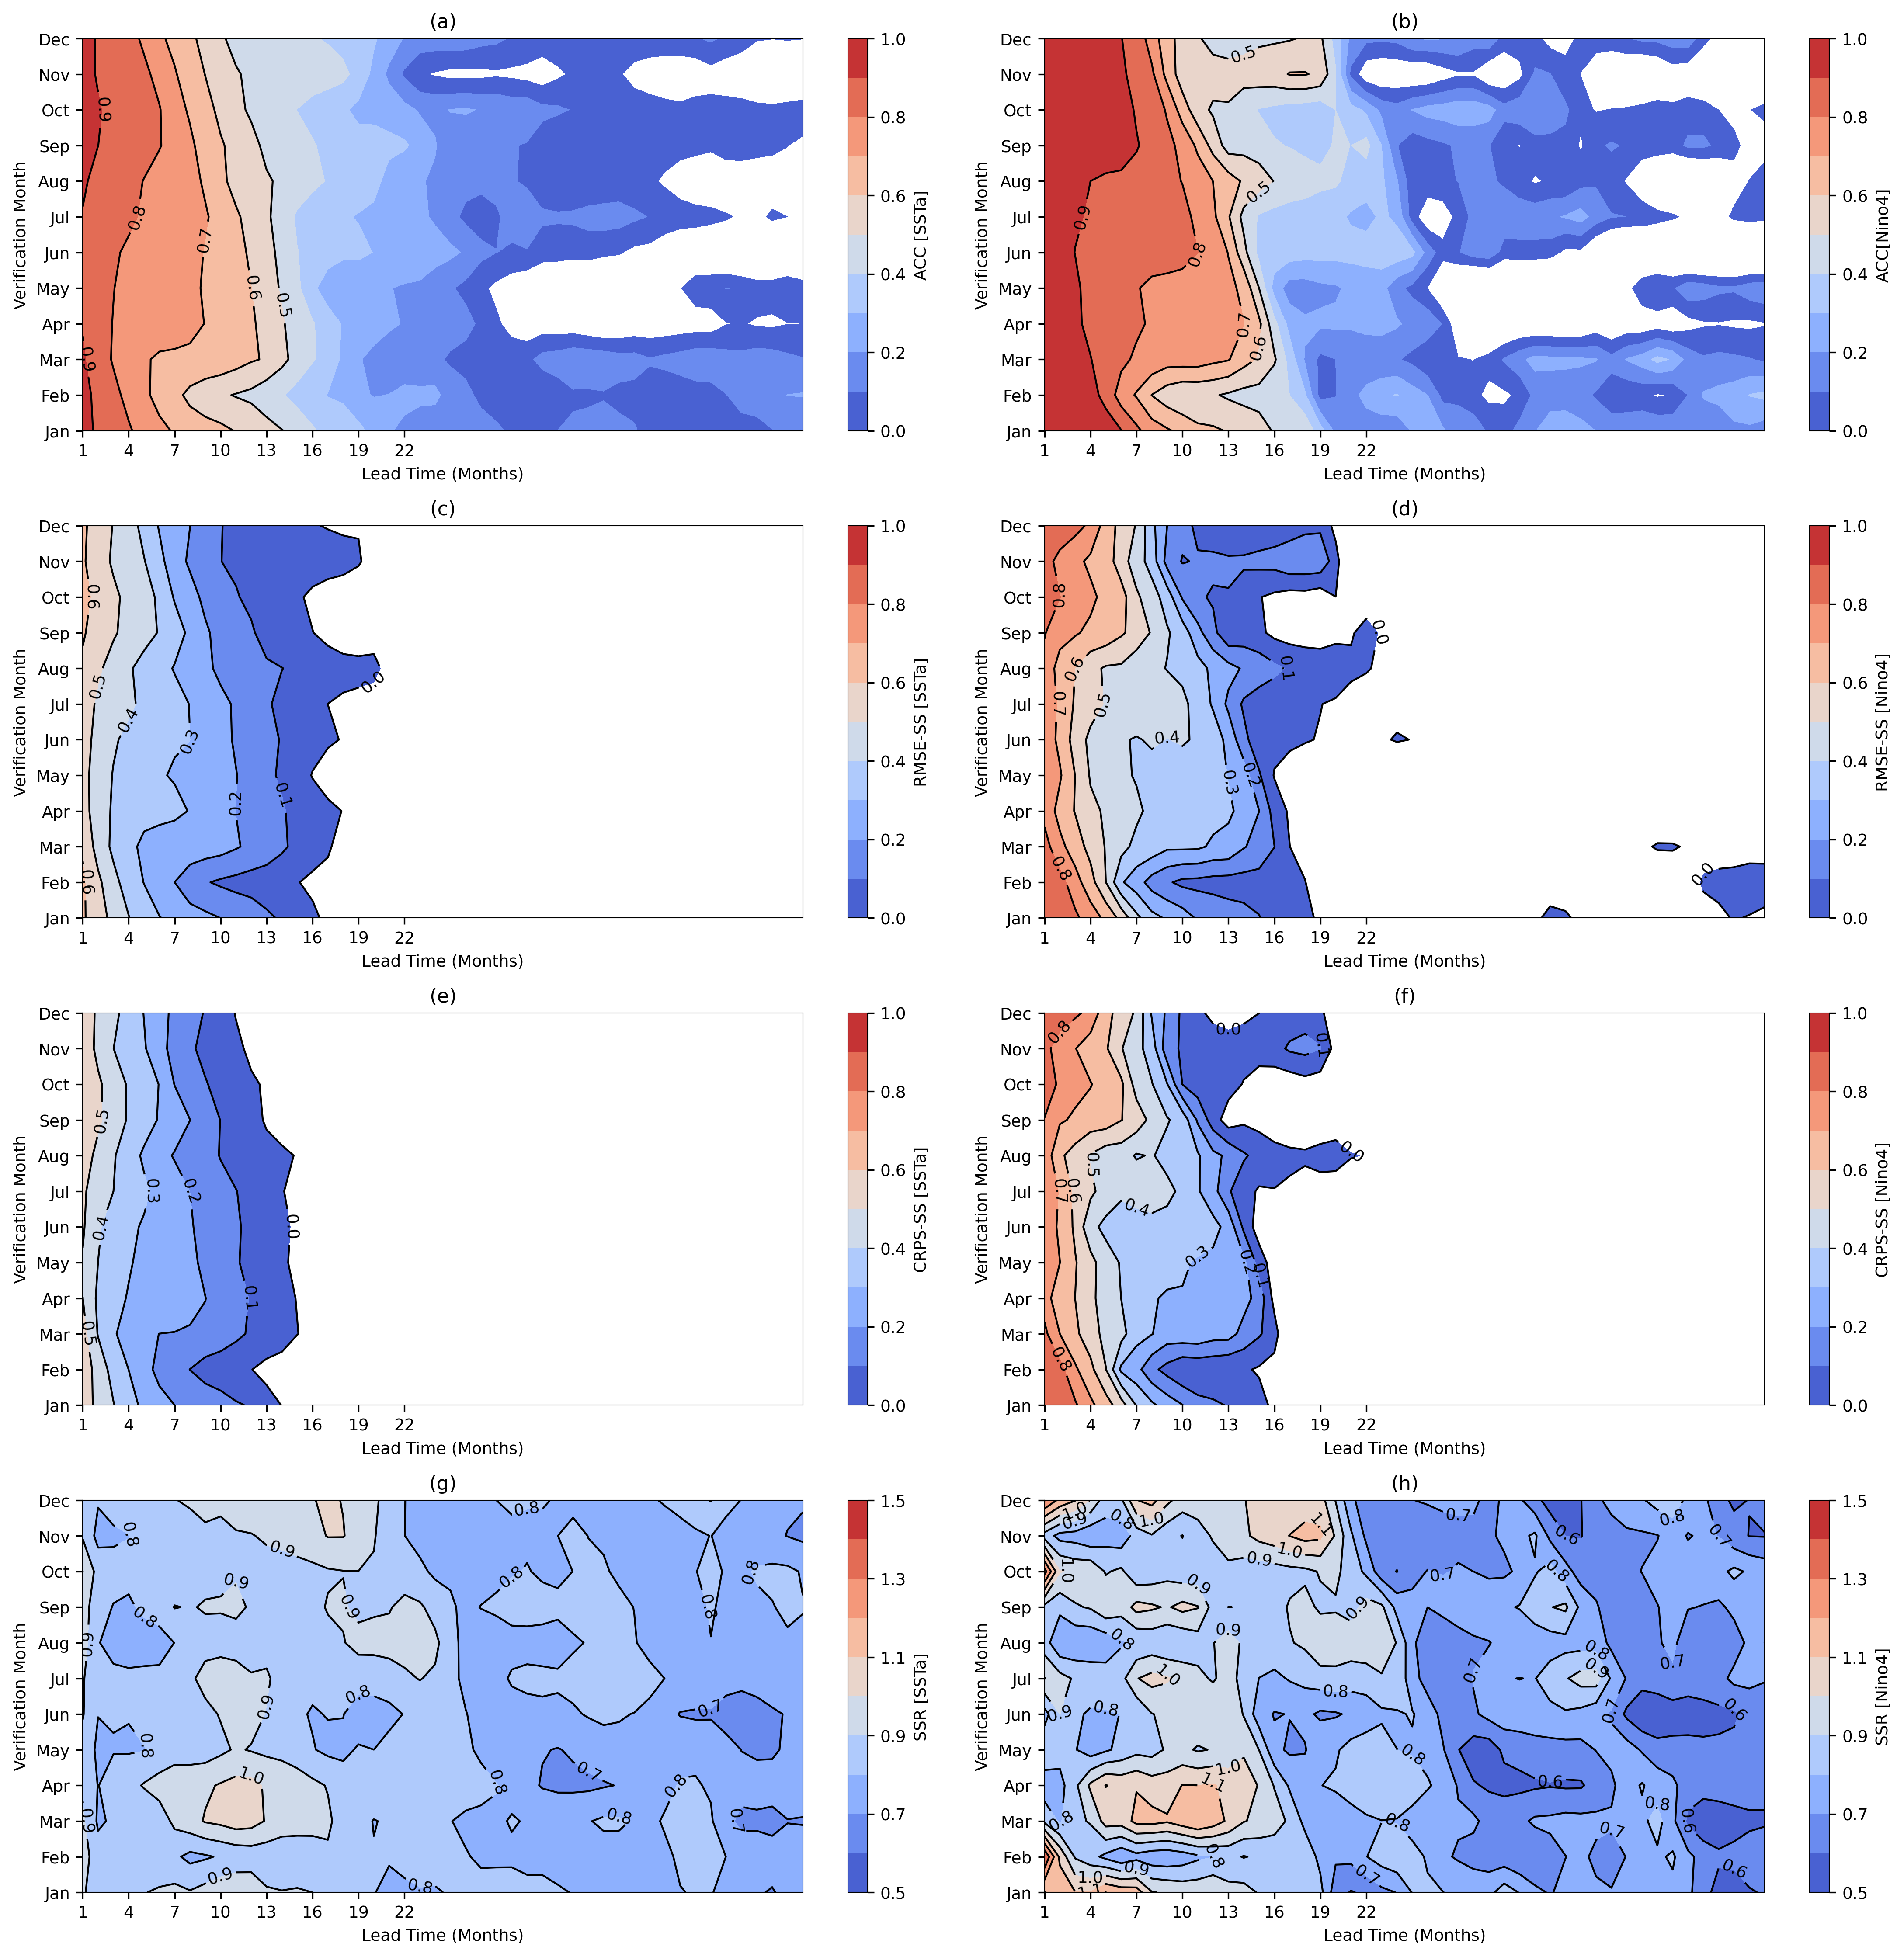

In [15]:
lev = np.linspace(0., 1., 11)
rmse_ss = (1 - monthly_rmse/clim_rmse)
nino_ss = (1 - monthly_nino_rmse/clim_nino_rmse)
crps_ss = (1 - monthly_crps/clim_crps)
nino_crps_ss = (1 - monthly_nino_crps/clim_nino_crps)

cmap = "coolwarm"

plt.figure(figsize = (15, 15))
plt.subplot(4, 2, 1)
filled = plt.contourf(monthly_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(a)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC [SSTa]")
plt.subplot(4, 2, 2)
filled = plt.contourf(monthly_nino_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_nino_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(b)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC[Nino4]")

plt.subplot(4, 2, 3)
filled = plt.contourf(rmse_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(rmse_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(c)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [SSTa]")
plt.subplot(4, 2, 4)
filled = plt.contourf(nino_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(d)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [Nino4]")

plt.subplot(4, 2, 5)
filled = plt.contourf(crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(e)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [SSTa]")
plt.subplot(4, 2, 6)
filled = plt.contourf(nino_crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(f)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [Nino4]")

plt.subplot(4, 2, 7)
filled = plt.contourf(monthly_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(g)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [SSTa]")
plt.subplot(4, 2, 8)
filled = plt.contourf(monthly_nino_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_nino_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(h)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [Nino4]")
plt.tight_layout()

plt.savefig('monthly.png')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_multilag_rank_histogram(obs_da, ens_da, lags_to_plot, title="Rank Histogram", save_path=None):
    """
    Generates a grouped rank histogram for multiple lags.
    
    Parameters:
        obs_da (xr.DataArray): Observed data with a 'lag' dimension.
        ens_da (xr.DataArray): Ensemble prediction with 'lag' and 'member' (or similar) dimensions.
        lags_to_plot (list): List of lag values to select and plot.
        title (str): Title for the plot.
        save_path (str, optional): File path to save the figure.
    """
    n = len(lags_to_plot)
    
    # 1) Generate Green Gradient
    bright_hex = '#00FF00'
    dark_hex   = '#006400'
    cmap = mcolors.LinearSegmentedColormap.from_list("green_grad", [bright_hex, dark_hex])
    colors = [cmap(i / (n - 1)) if n > 1 else cmap(0) for i in range(n)]

    fig, ax = plt.subplots(figsize=(6, 3))
    width = 0.8 / n  # Dynamic width based on number of lags
    
    # We'll need these for axis formatting later
    bins = None
    expected_count = None

    for i, lag_val in enumerate(lags_to_plot):
        # Select data
        obs = obs_da.sel(lag=lag_val).values.flatten()
        ens = ens_da.sel(lag=lag_val).values
        
        # Reshape ens if it's SSTA (lat/lon) to (samples, members)
        # Assuming the last dimension is the ensemble member
        if ens.ndim > 2:
            ens = ens.reshape(-1, ens.shape[-1])
            
        # Mask NaNs
        valid_mask = (~np.isnan(obs)) & (~np.isnan(ens).any(axis=-1))
        obs_valid = obs[valid_mask]
        ens_valid = ens[valid_mask, :]
        
        if len(obs_valid) == 0:
            print(f"Warning: No valid data for lag {lag_val}")
            continue

        # Compute rank histogram (assumes this function is defined in your env)
        rank_counts = compute_rank_histogram(obs_valid, ens_valid)
        
        num_members = ens_valid.shape[1]
        bins = np.arange(num_members + 1)
        expected_count = rank_counts.sum() / (num_members + 1)

        # Plot bars
        ax.bar(bins + (i * width),
               rank_counts,
               width=width,
               alpha=0.8,
               color=colors[i],
               edgecolor="black",
               label=f"Lag {lag_val}")

    # 2) Formatting
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Rank (0 = below all, N = above all)")
    
    if expected_count is not None:
        ax.axhline(expected_count, color="red", linestyle="dashed", linewidth=1, label="Ideal", zorder=0)

    # Center ticks
    if bins is not None:
        ax.set_xticks(bins + (width * (n - 1) / 2))
        ax.set_xticklabels(bins)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        
    plt.show()

Saved: nino4_rank_hist.png


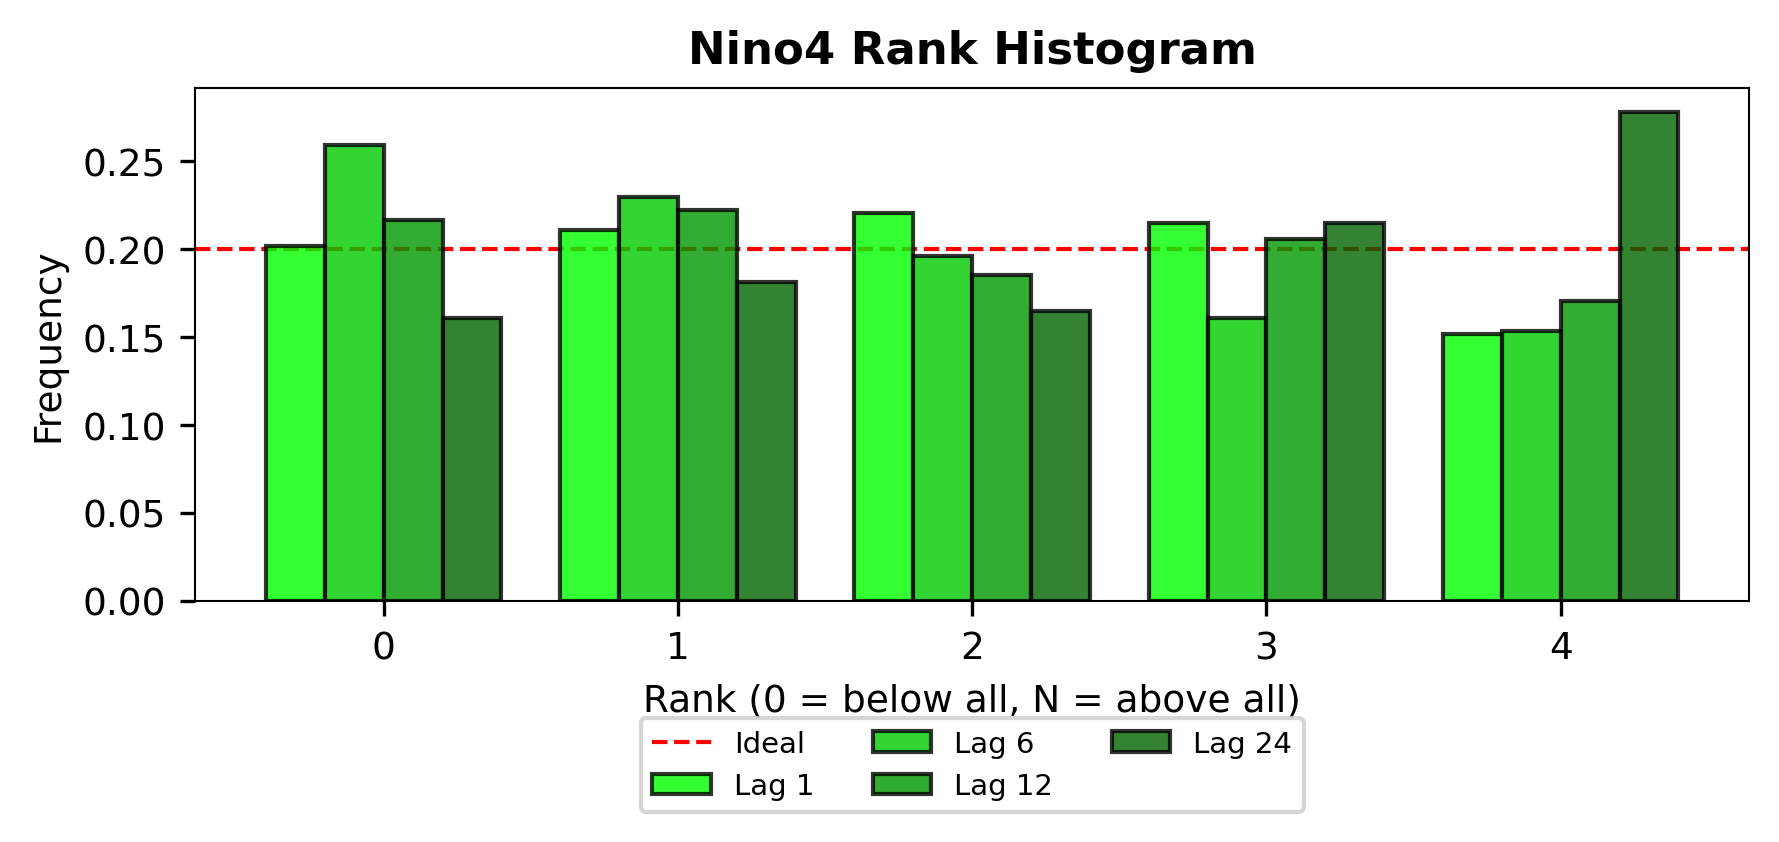

Saved: ssta_spatial_rank_hist.png


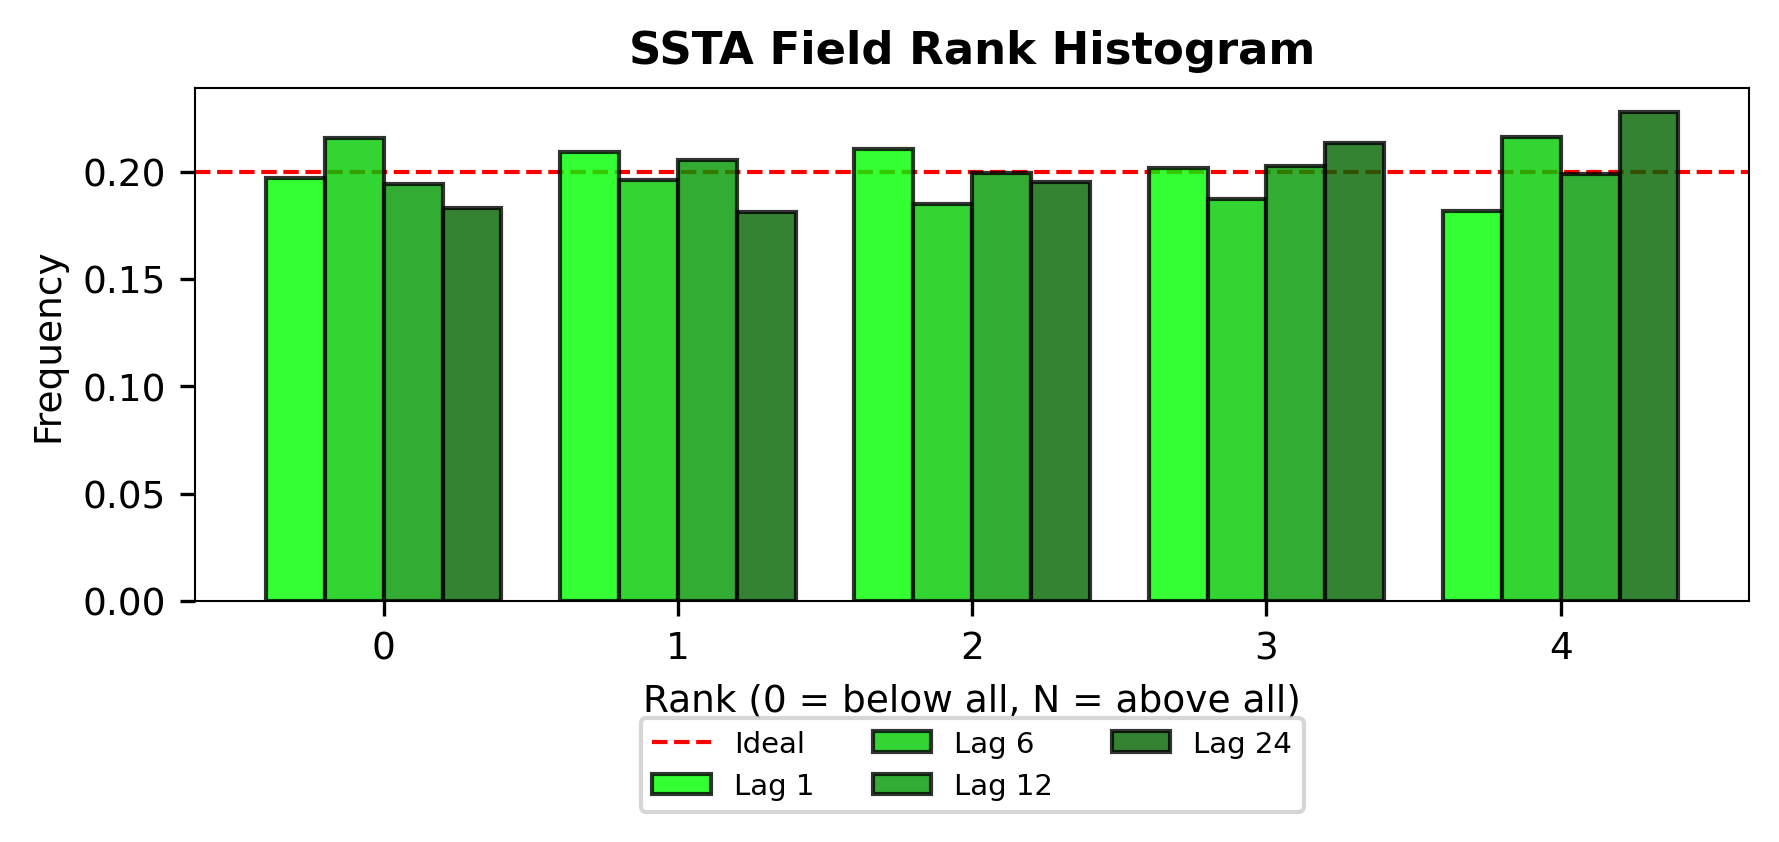

In [17]:
plot_multilag_rank_histogram(
    filtered_tgt_nino4, 
    filtered_pred_nino4, 
    lags_to_plot=[1, 6, 12, 24], 
    title="Nino4 Rank Histogram",
    save_path="nino4_rank_hist.png"
)

plot_multilag_rank_histogram(
    filtered_tgt, 
    filtered_pred, 
    lags_to_plot=[1, 6, 12, 24], 
    title="SSTA Field Rank Histogram",
    save_path="ssta_spatial_rank_hist.png"
)

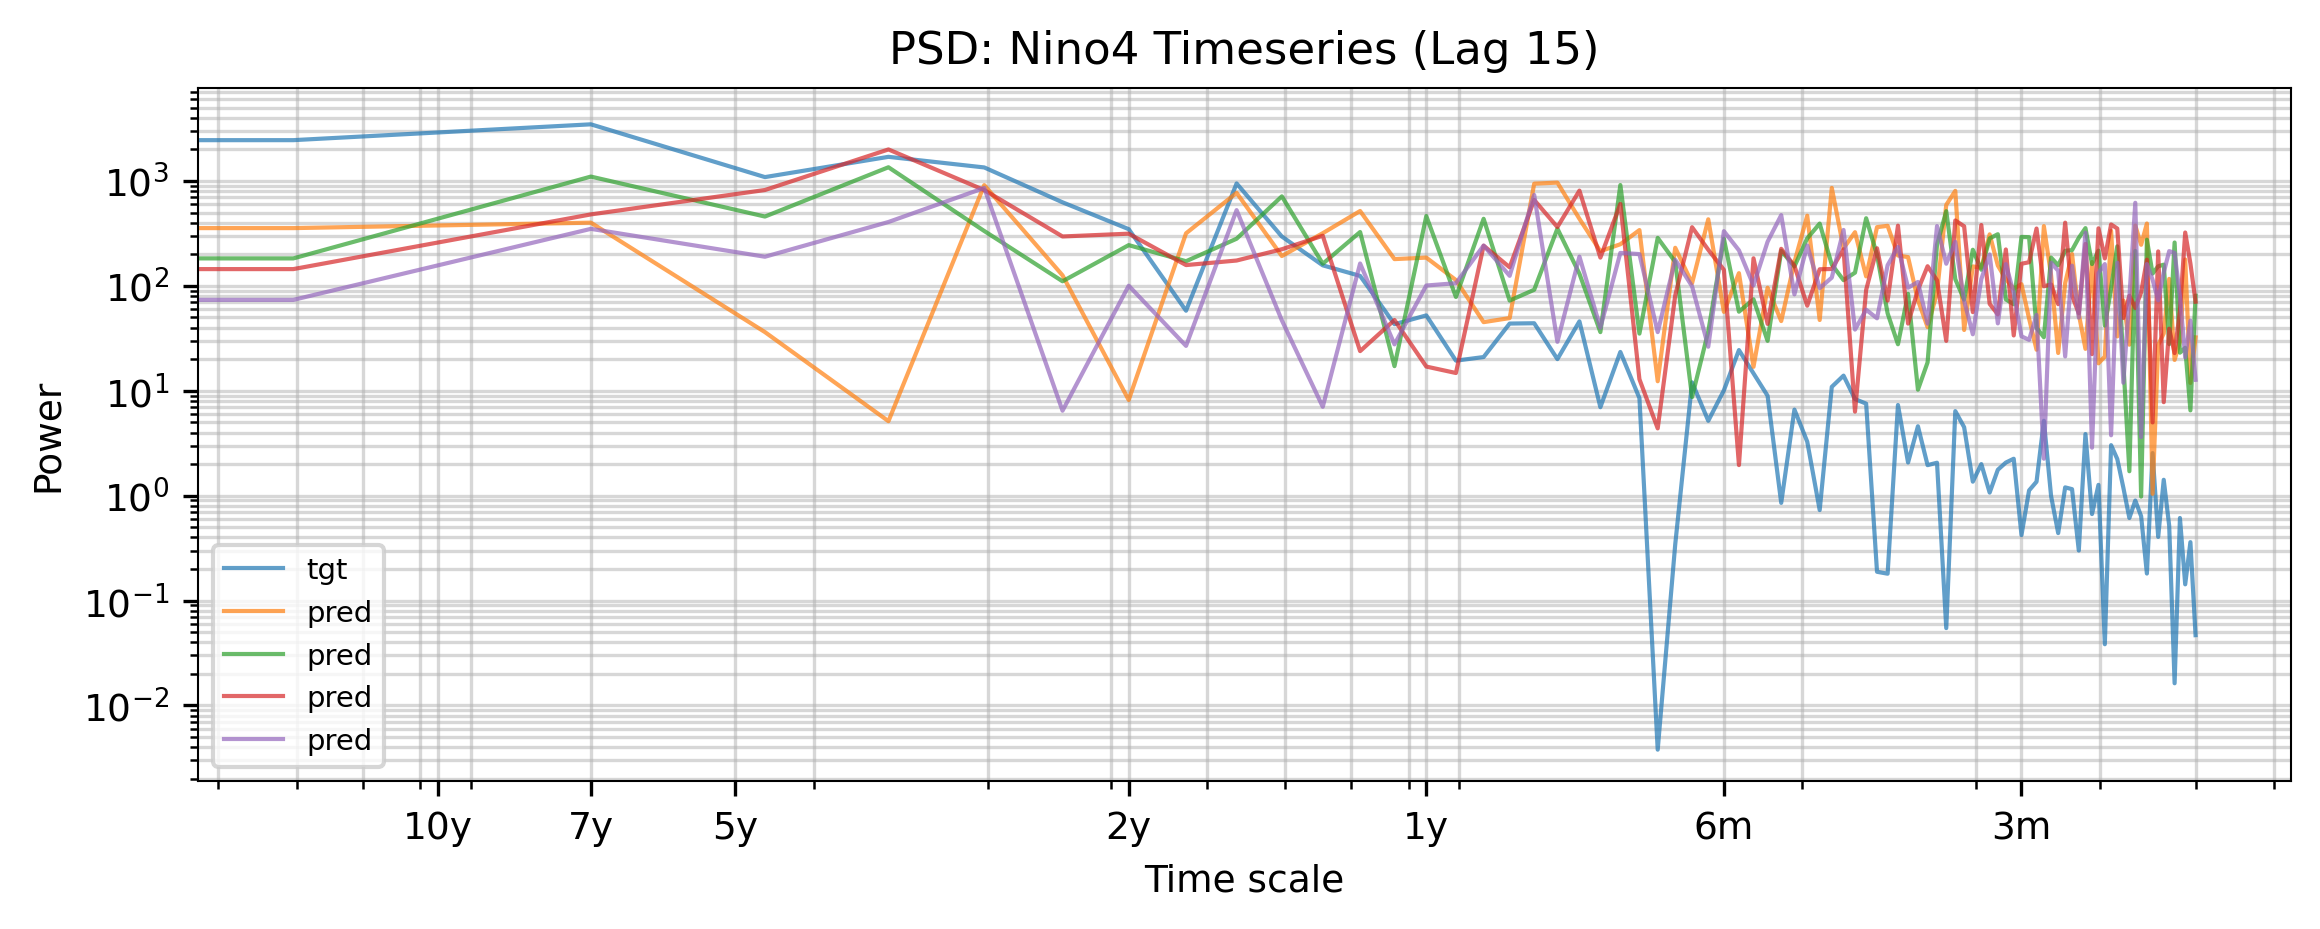

In [18]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import numpy as np
T = 1
tau = 15
y = filtered_tgt_nino4.sel(lag = tau, time = slice('1981', '2020'))
z = filtered_pred_nino4.sel(lag = tau, time = slice('1981', '2020'))

T = 1 # 1 month
N = len(z.time)

xf = rfftfreq(N, T)

plt.figure(figsize=(9, 3))
plt.plot(xf, np.abs(rfft(y)) ** 2, '-', label='tgt', alpha=0.7)
plt.plot(xf, np.abs(rfft(z, axis=0)) ** 2, '-', label=f'pred', alpha=0.7)


periods_months = np.array([3, 6, 12, 24, 60, 84, 120]) 
tick_freqs = 1 / periods_months
tick_labels = ['3m', '6m', '1y', '2y', '5y', '7y', '10y']

plt.yscale('log')
plt.xscale('log')
plt.xticks(tick_freqs, tick_labels)
plt.xlabel('Time scale')
plt.ylabel('Power')
plt.title(f'PSD: Nino4 Timeseries (Lag {tau})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


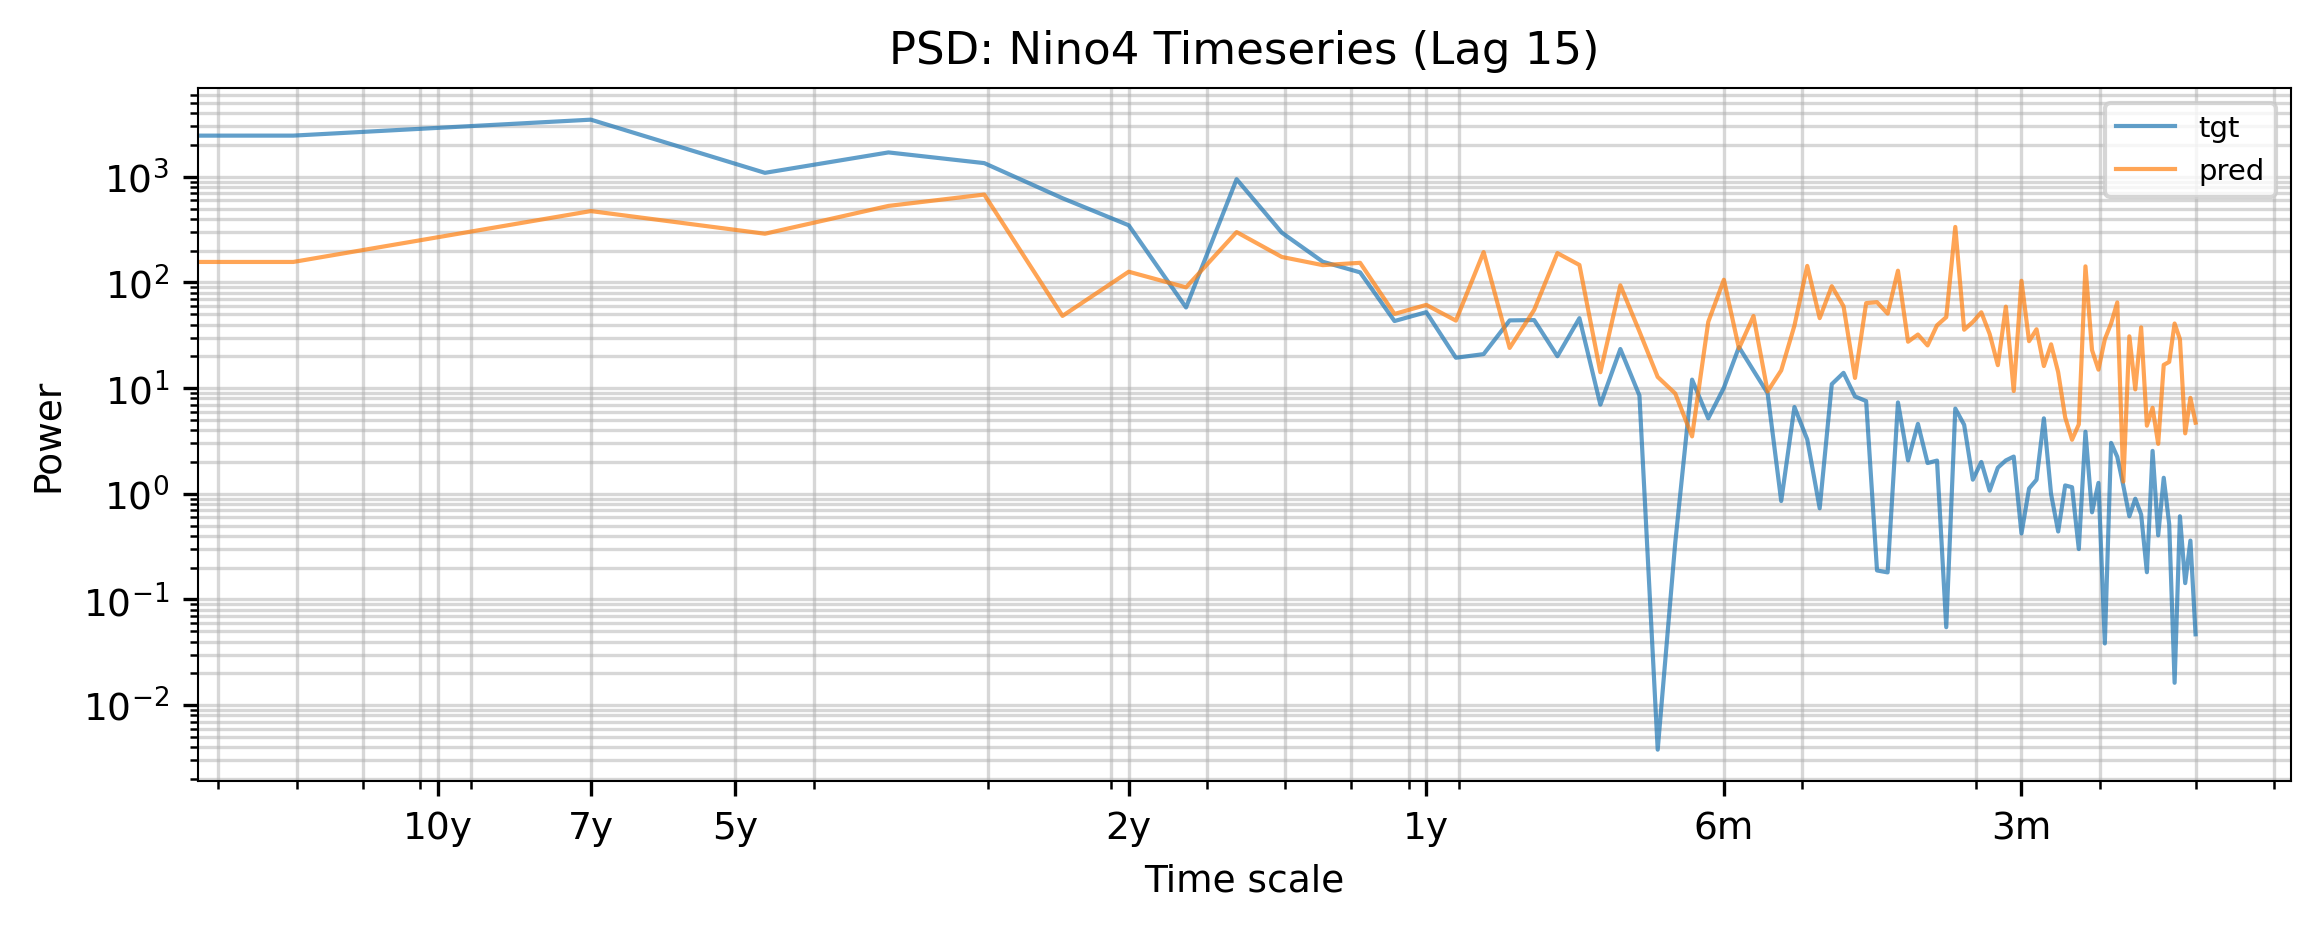

In [19]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import numpy as np
T = 1
tau = 15
y = filtered_tgt_nino4.sel(lag = tau, time = slice('1981', '2020'))
z = filtered_pred_nino4.sel(lag = tau, time = slice('1981', '2020')).mean('ens')

T = 1 # 1 month
N = len(z.time)

xf = rfftfreq(N, T)

plt.figure(figsize=(9, 3))
plt.plot(xf, np.abs(rfft(y)) ** 2, '-', label='tgt', alpha=0.7)
plt.plot(xf, np.abs(rfft(z, axis=0)) ** 2, '-', label=f'pred', alpha=0.7)


periods_months = np.array([3, 6, 12, 24, 60, 84, 120]) 
tick_freqs = 1 / periods_months
tick_labels = ['3m', '6m', '1y', '2y', '5y', '7y', '10y']

plt.yscale('log')
plt.xscale('log')
plt.xticks(tick_freqs, tick_labels)
plt.xlabel('Time scale')
plt.ylabel('Power')
plt.title(f'PSD: Nino4 Timeseries (Lag {tau})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


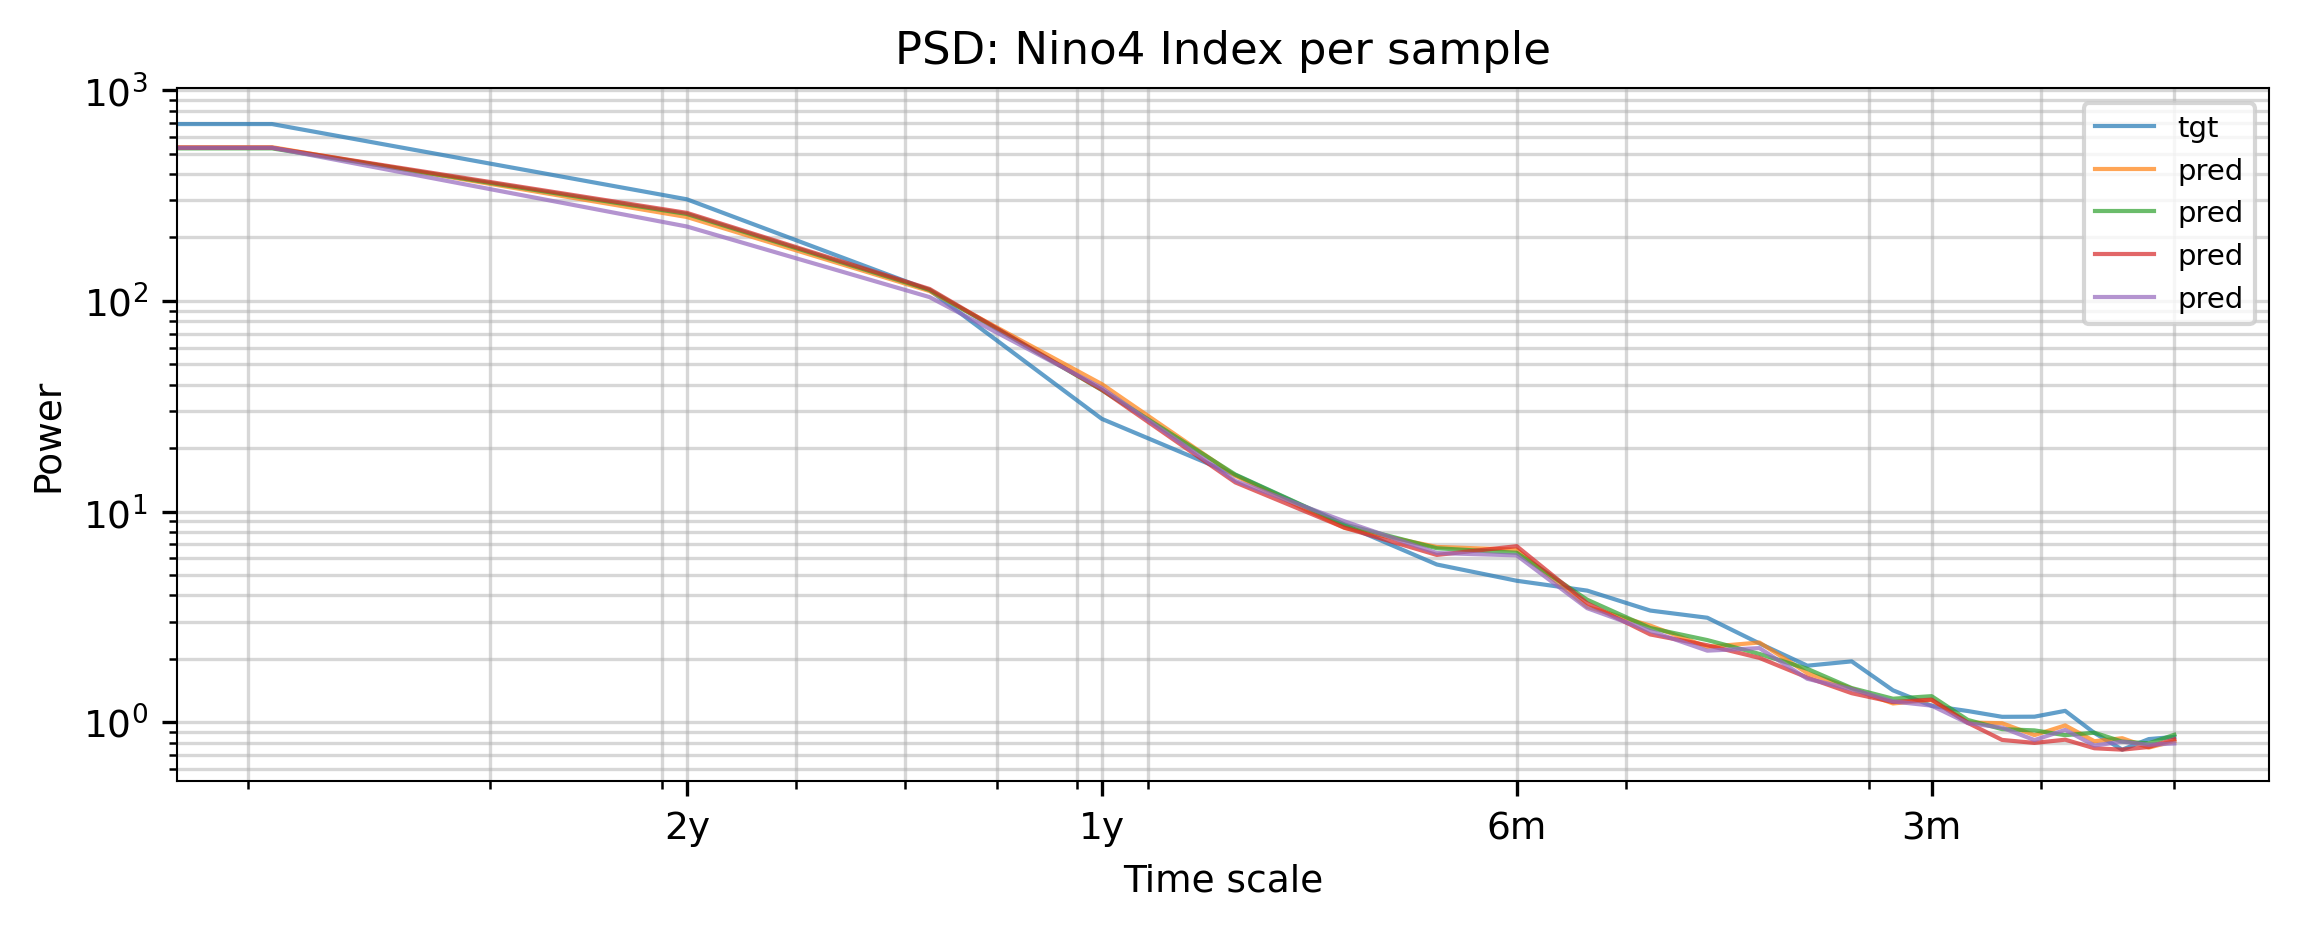

In [20]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import numpy as np
T = 1 # 1 month
N = len(eval_data.lag)

psd_tgt, psd_src = [], []

for t in range(len(filtered_tgt_nino4.time) - N):
    y = filtered_tgt_nino4.isel(time = t)
    z = filtered_pred_nino4.isel(time = t)
    psd_tgt.append( np.abs(rfft(y)) ** 2 )
    psd_src.append( np.abs(rfft(z, axis = 0)) ** 2 )

psd_tgt = np.mean( np.array(psd_tgt), axis = 0)
psd_src = np.mean( np.array(psd_src), axis = 0)

xf = rfftfreq(N, T)

plt.figure(figsize=(9, 3))
plt.plot(xf, psd_tgt, '-', label='tgt', alpha=0.7)
plt.plot(xf, psd_src, '-', label=f'pred', alpha=0.7)


periods_months = np.array([3, 6, 12, 24]) 
tick_freqs = 1 / periods_months
tick_labels = ['3m', '6m', '1y', '2y']

plt.yscale('log')
plt.xscale('log')
plt.xticks(tick_freqs, tick_labels)
plt.xlabel('Time scale')
plt.ylabel('Power')
plt.title(f'PSD: Nino4 Index per sample')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()




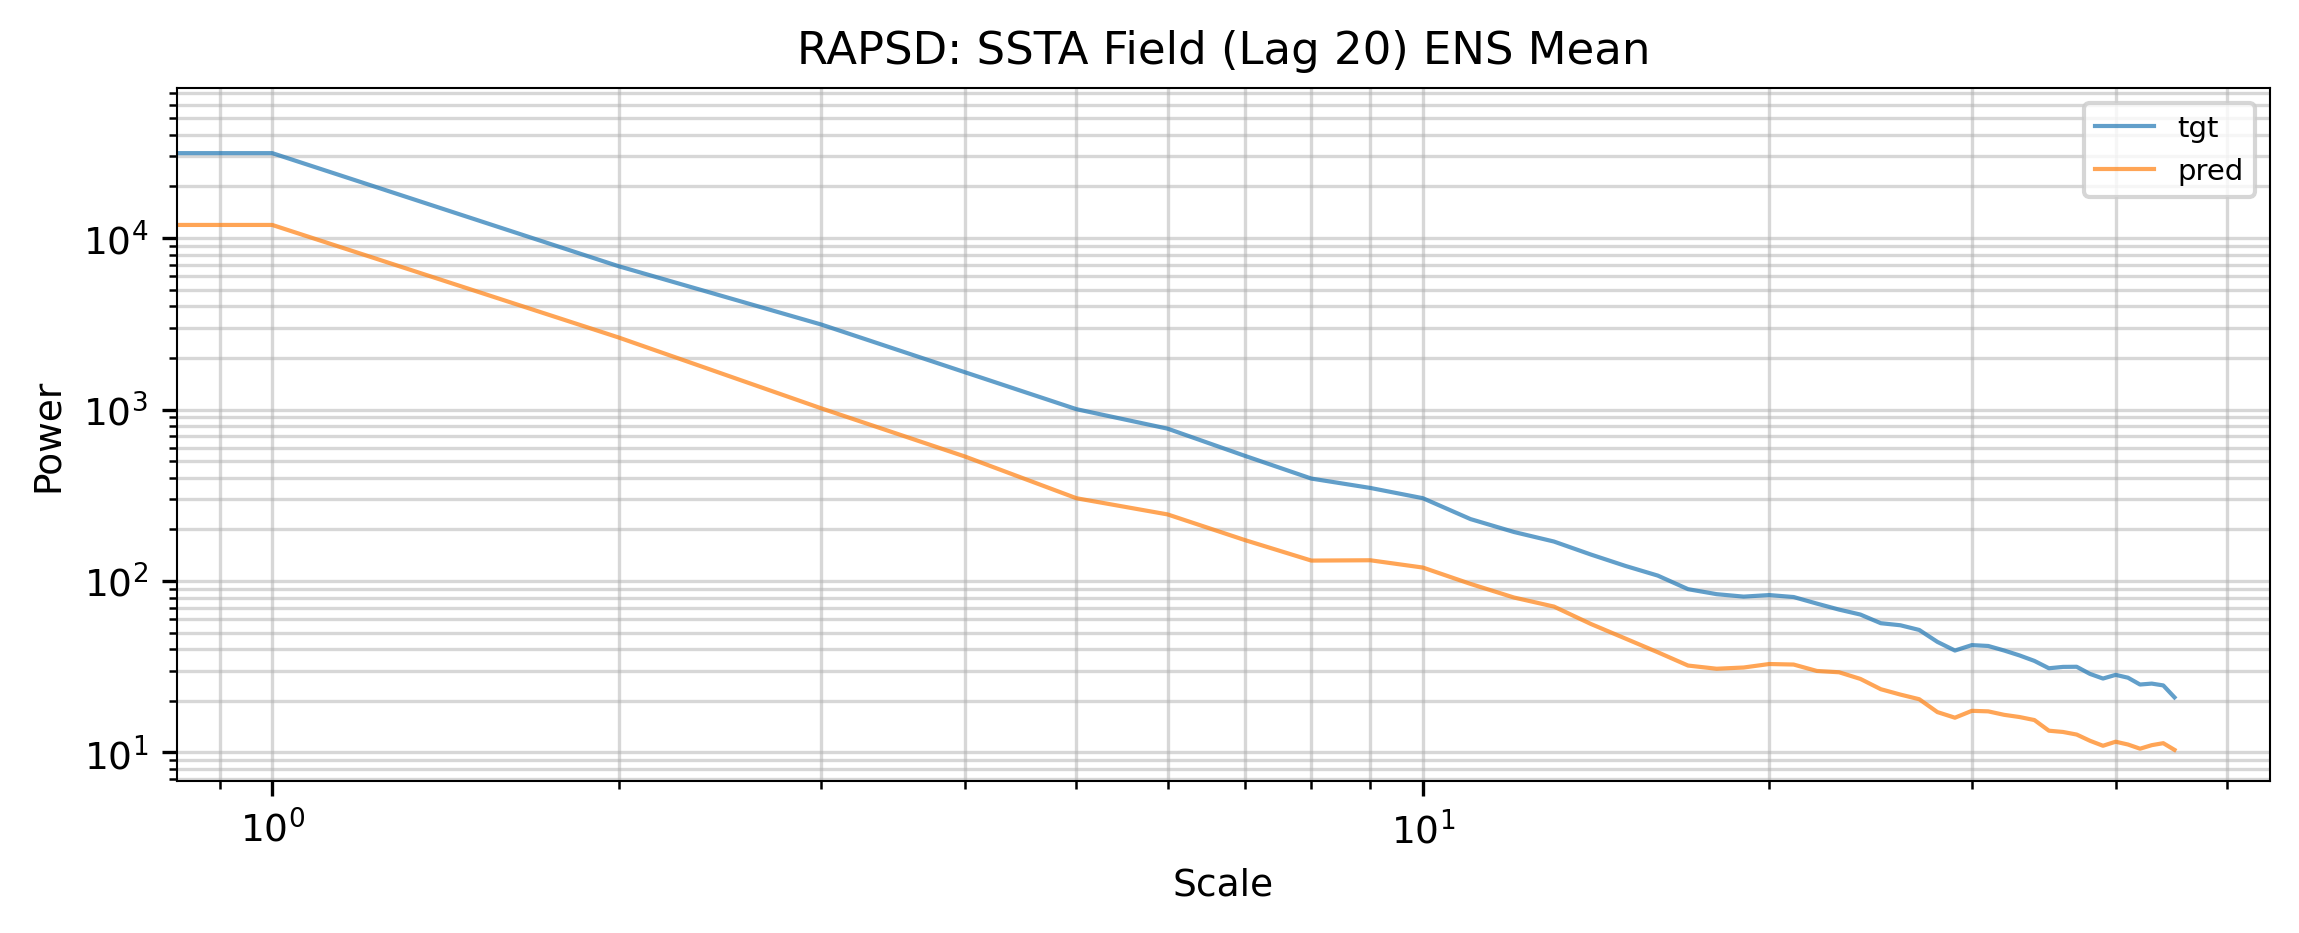

In [21]:
from scipy.fft import rfft2, rfftfreq

tau = 20
rapsd_tgt, rapsd_src = [], []


for t in range(len(filtered_tgt.time) - N):
    rapds_tgt_t = np.abs(rfft2(filtered_tgt.isel(time = t, lag = tau).fillna(0))) ** 2
    rapds_src_t = np.abs(rfft2(filtered_pred.isel(time = t, lag = tau).mean('ens').fillna(0))) ** 2
    rapds_tgt_t = rapds_tgt_t.mean(axis = 0)
    rapds_src_t = rapds_src_t.mean(axis = 0)
    rapsd_tgt.append( rapds_tgt_t )
    rapsd_src.append( rapds_src_t )

rapsd_tgt = np.mean( np.array(rapsd_tgt), axis = 0)
rapsd_src = np.mean( np.array(rapsd_src), axis = 0)

plt.figure(figsize=(9, 3))
plt.plot(rapsd_tgt, '-', label='tgt', alpha=0.7)
plt.plot(rapsd_src, '-', label=f'pred', alpha=0.7)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Scale')
plt.ylabel('Power')
plt.title(f'RAPSD: SSTA Field (Lag {tau}) ENS Mean')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()




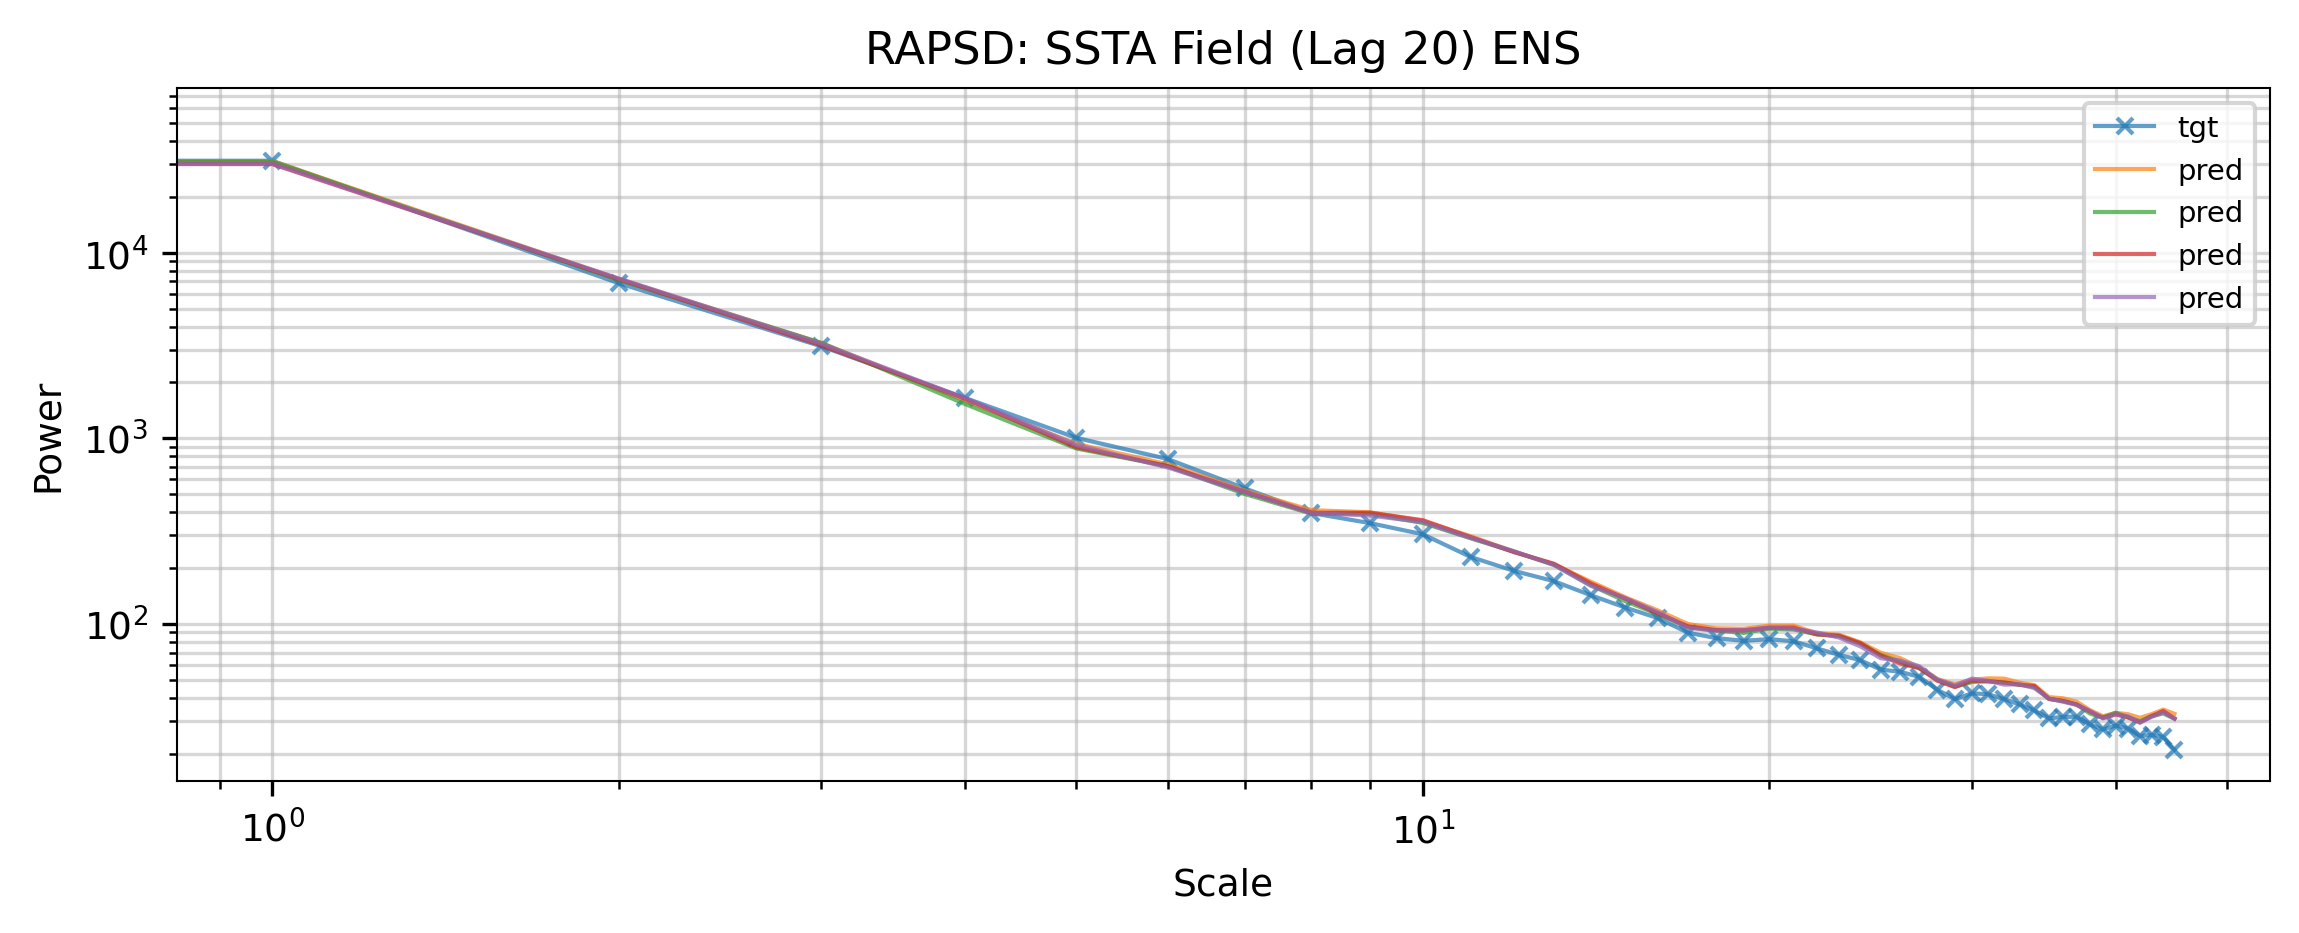

In [22]:
from scipy.fft import rfft2, rfftfreq

tau = 20
rapsd_tgt, rapsd_src = [], []


for t in range(len(filtered_tgt.time) - N):
    rapds_tgt_t = np.abs(rfft2(filtered_tgt.isel(time = t, lag = tau).fillna(0), axes=[0,1])) ** 2
    rapds_src_t = np.abs(rfft2(filtered_pred.isel(time = t, lag = tau).fillna(0), axes=[0,1])) ** 2
    rapds_tgt_t = rapds_tgt_t.mean(axis = 0)
    rapds_src_t = rapds_src_t.mean(axis = 0)
    rapsd_tgt.append( rapds_tgt_t )
    rapsd_src.append( rapds_src_t )

rapsd_tgt = np.mean( np.array(rapsd_tgt), axis = 0)
rapsd_src = np.mean( np.array(rapsd_src), axis = 0)

plt.figure(figsize=(9, 3))
plt.plot(rapsd_tgt, 'x-', label='tgt', alpha=0.7, markersize=4)
plt.plot(rapsd_src, '-', label=f'pred', alpha=0.7)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Scale')
plt.ylabel('Power')
plt.title(f'RAPSD: SSTA Field (Lag {tau}) ENS')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()




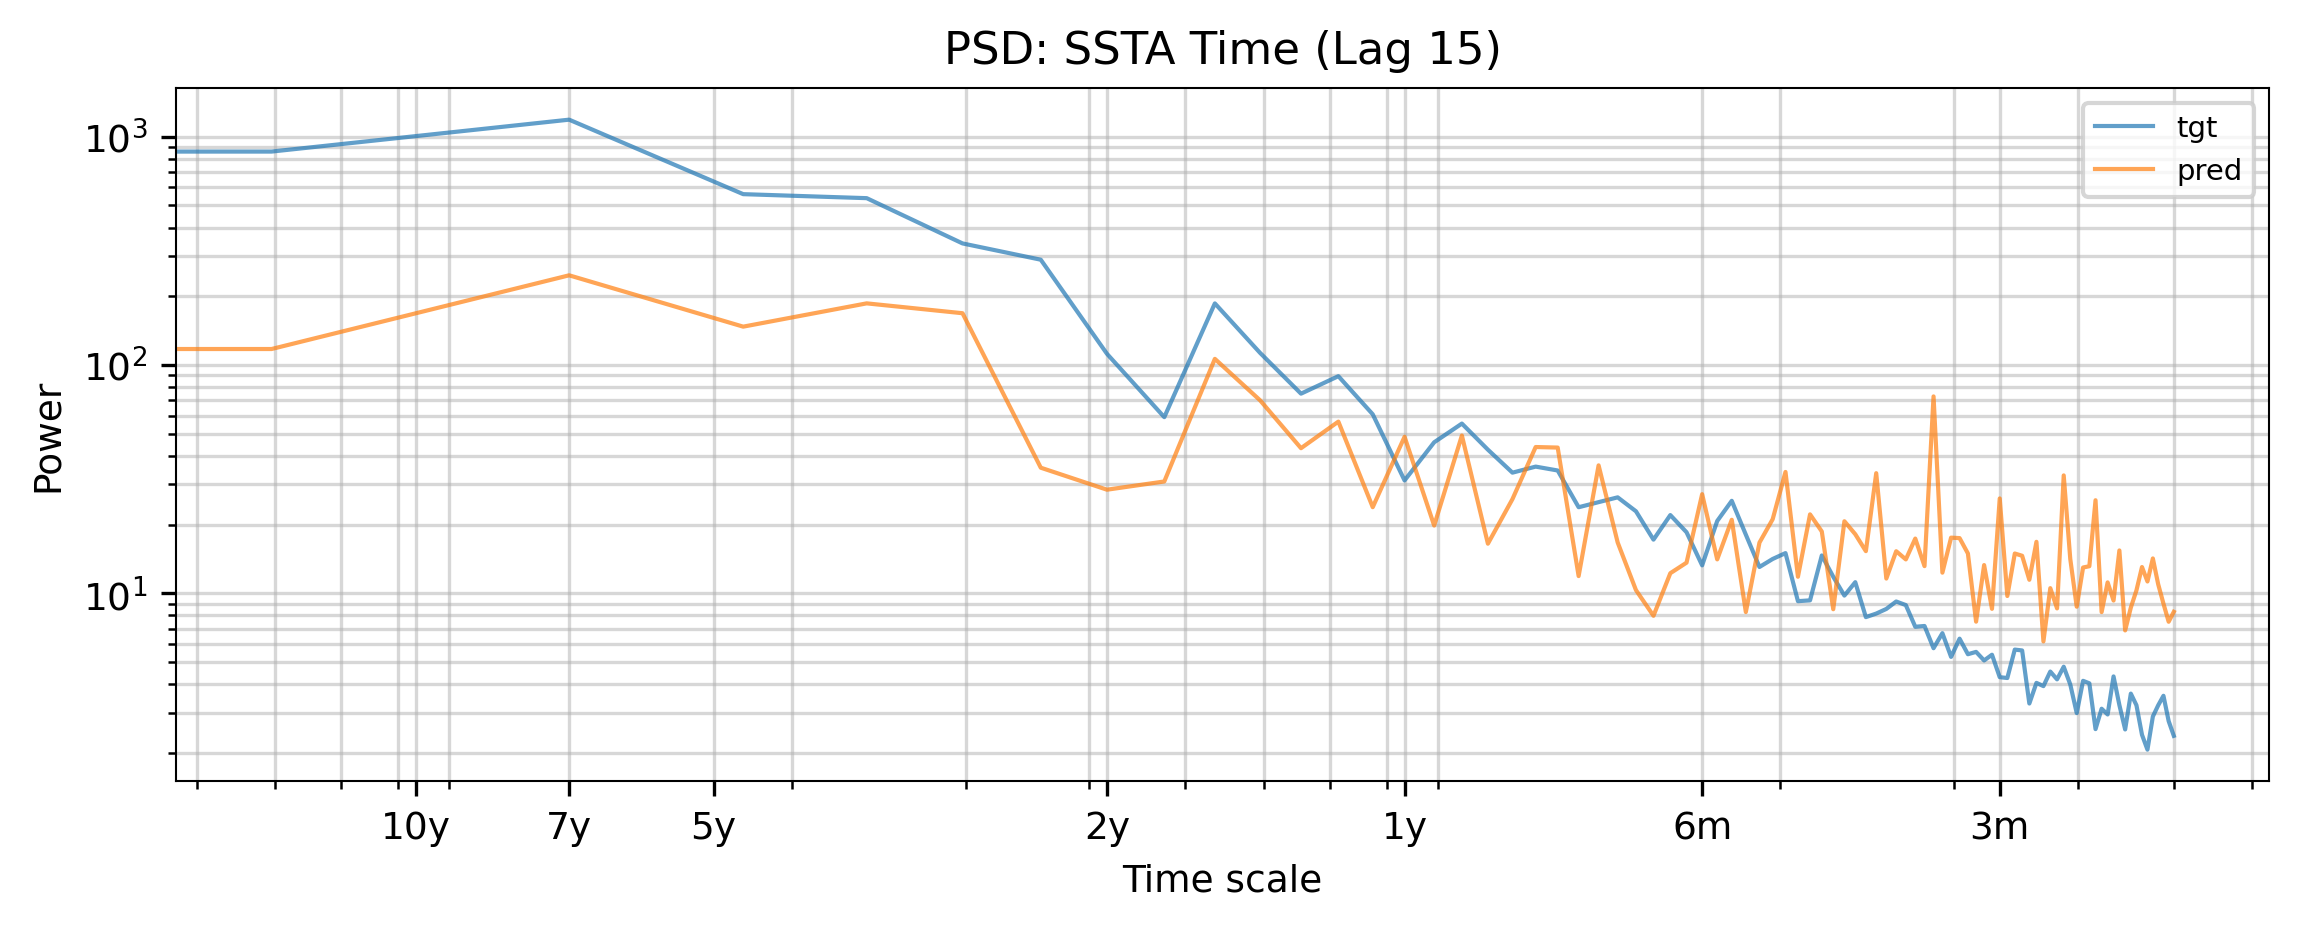

In [23]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import numpy as np
T = 1
tau = 15
y = filtered_tgt.sel(lag = tau, time = slice('1981', '2020')).fillna(0)
z = filtered_pred.sel(lag = tau, time = slice('1981', '2020')).mean('ens').fillna(0)

T = 1 # 1 month
N = len(z.time)

xf = rfftfreq(N, T)

plt.figure(figsize=(9, 3))
plt.plot(xf, (np.abs(rfft(y, axis = 0)) ** 2).mean(axis = (1,2)), '-', label='tgt', alpha=0.7)
plt.plot(xf, (np.abs(rfft(z, axis = 0)) ** 2).mean(axis = (1,2)), '-', label=f'pred', alpha=0.7)


periods_months = np.array([3, 6, 12, 24, 60, 84, 120]) 
tick_freqs = 1 / periods_months
tick_labels = ['3m', '6m', '1y', '2y', '5y', '7y', '10y']

plt.yscale('log')
plt.xscale('log')
plt.xticks(tick_freqs, tick_labels)
plt.xlabel('Time scale')
plt.ylabel('Power')
plt.title(f'PSD: SSTA Time (Lag {tau})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


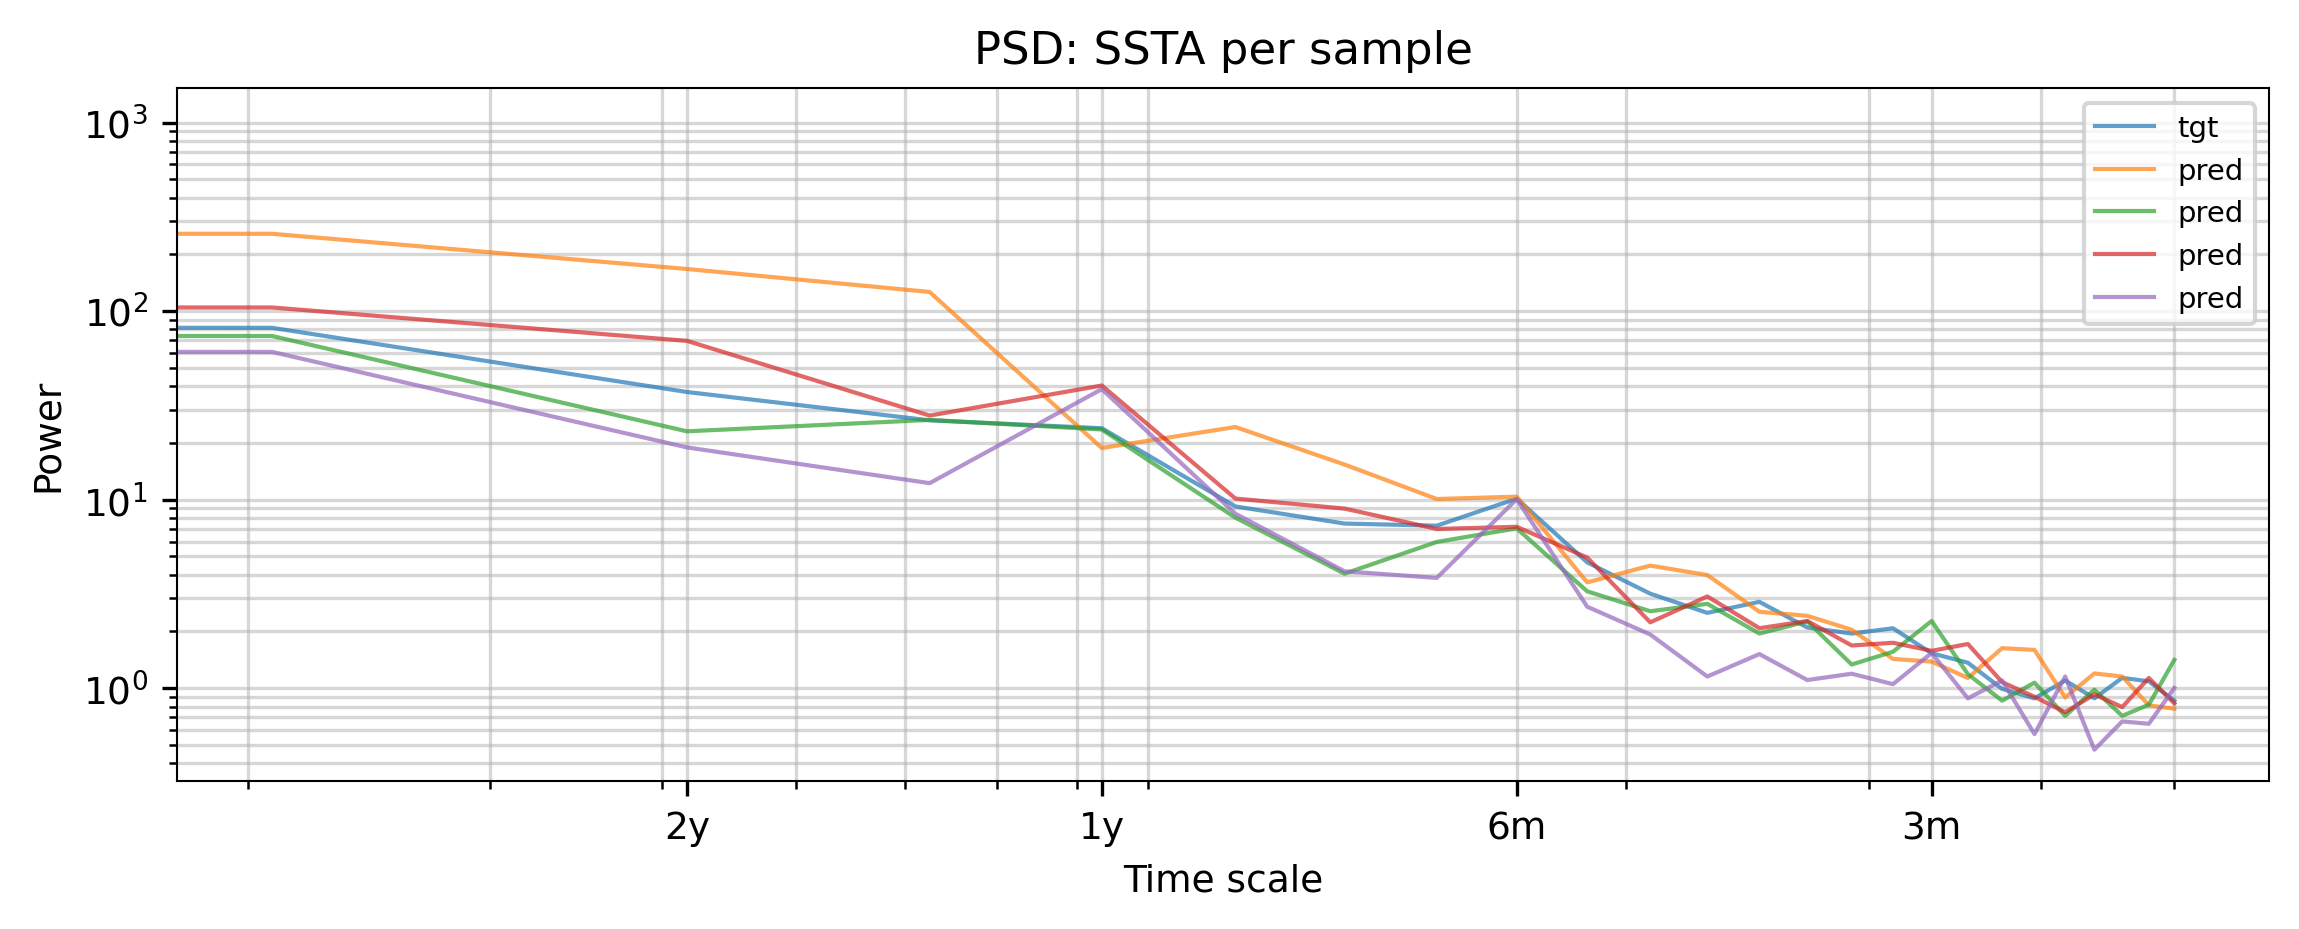

In [24]:

T = 1 # 1 month
N = len(eval_data.lag)


y = filtered_tgt.isel(time = t).fillna(0)
z = filtered_pred.isel(time = t).fillna(0)

psd_tgt = np.abs(rfft(y, axis = 0)) ** 2
psd_tgt = psd_tgt.mean(axis = (1,2))
psd_src = np.abs(rfft(z, axis = 0)) ** 2
psd_src = psd_src.mean(axis = (1,2))

xf = rfftfreq(N, T)

plt.figure(figsize=(9, 3))
plt.plot(xf, psd_tgt, '-', label='tgt', alpha=0.7)
plt.plot(xf, psd_src, '-', label=f'pred', alpha=0.7)


periods_months = np.array([3, 6, 12, 24]) 
tick_freqs = 1 / periods_months
tick_labels = ['3m', '6m', '1y', '2y']

plt.yscale('log')
plt.xscale('log')
plt.xticks(tick_freqs, tick_labels)
plt.xlabel('Time scale')
plt.ylabel('Power')
plt.title(f'PSD: SSTA per sample')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


